In [2]:
%reload_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

from pathlib import Path
from sys import path
from typing import Dict, List

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
import statsmodels.api as sm
from pymc_marketing.clv import ParetoNBDModel, plot_expected_purchases_over_time
from pymc_marketing.clv.models.gamma_gamma import GammaGammaModel
from pymc_marketing.clv.utils import rfm_train_test_split
from pymc_marketing.prior import Prior
from scipy.stats import gamma, kendalltau, pearsonr, spearmanr
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.preprocessing import RobustScaler
from statsmodels.robust.robust_linear_model import RLM, RLMResultsWrapper
from tqdm import tqdm
from xarray import DataArray, concat

path.append(str(Path.cwd().parent))
from src.model_utils import (
    create_btyd_model_config_mle,
    create_spend_model_config_mle,
    run_pnbd_ppcs,
)

## Globals

In [3]:
pd.set_option("mode.copy_on_write", True)

az.style.use("arviz-darkgrid")

seed: int = 27

random_state: np.random.RandomState = np.random.RandomState(seed=seed)

rng: np.random.Generator = np.random.default_rng(seed=seed)

In [4]:
data_path: Path = Path.cwd().parent / "data" / "processed"
model_path: Path = Path.cwd().parent / "models"

for path in [model_path]:
    Path(path).mkdir(parents=True, exist_ok=True)

## Data

In [7]:
data = pd.read_parquet(data_path / "transactions.parquet")

data = data.astype({"account_number": str, "transaction_amount": float})

data.dtypes

transaction_amount             float64
account_number                  object
transaction_datetime    datetime64[ns]
dtype: object

Keep only non-zero transactions only:

In [8]:
zero_counts = data[data["transaction_amount"] == 0].shape[0]

zero_counts

22103

In [9]:
data = data.loc[data["transaction_amount"] > 0]

data.shape

(751843, 3)

### Aggregate Data for Modeling

This dataset summarizes customer purchasing behavior using the RFM (Recency, Frequency, Monetary) model, which is commonly used for customer segmentation and lifetime value prediction.

- **`customer_id`**: Unique identifier for each customer, corresponding to the `account_number` in the original transactions dataset.

- **`frequency`**: The total number of repeat purchases made by the customer. It is calculated as the total number of transactions **minus one** (since the first purchase isn't considered a repeat). For example, if a customer has made 5 purchases, their frequency will be 4.

- **`recency`**: The time elapsed (in **seconds**) between the customer's most recent purchase and the end of the observation period. A **lower recency** value indicates a more recent purchase, while a **higher recency** implies the customer hasn't made a purchase recently.  
  - **Note**: If a customer has only made one purchase, `recency` is set to **0**.

- **`T`**: The customer’s “age” or tenure, measured in **seconds**. It represents the time between a customer’s first purchase and the end of the observation period. This metric indicates how long the customer has been active.

- **`monetary_value`**: The average amount spent per transaction by the customer, calculated from all their transactions. It reflects the customer's typical spending behavior.

### Train-Validation-Test Split

In [10]:
data.transaction_datetime.min(), data.transaction_datetime.max()

(Timestamp('2016-01-01 00:01:02'), Timestamp('2016-12-30 23:59:45'))

In [11]:
train_period_end: str = "2016-09-30"
validation_period_end: str = "2016-12-30"

train_val_data = rfm_train_test_split(
    transactions=data,
    customer_id_col="account_number",
    datetime_col="transaction_datetime",
    monetary_value_col="transaction_amount",
    train_period_end=train_period_end,
    test_period_end=validation_period_end,
    time_unit="D",
    include_first_transaction=False,
)

train_columns: List[str] = [
    "customer_id",
    "frequency",
    "recency",
    "T",
    "monetary_value",
]
train_data: pd.DataFrame = train_val_data[train_columns]
validation_data: pd.DataFrame = train_val_data.loc[
    :, ["customer_id"] + list(set(train_val_data.columns) - set(train_columns))
]

print(f"Train Data Shape: {train_data.shape}")
print(f"Validation Data Shape: {validation_data.shape}")

Train Data Shape: (4961, 5)
Validation Data Shape: (4961, 4)


In [12]:
train_data.head()

,customer_id,frequency,recency,T,monetary_value
0,100088067,46.0,261.0,262.0,118.832827
1,100108752,11.0,140.0,146.0,59.911817
2,100328049,60.0,265.0,267.0,160.103334
3,100663626,17.0,236.0,261.0,152.230588
4,100737756,96.0,262.0,267.0,240.985938


In [13]:
validation_data.head()

,customer_id,test_monetary_value,test_T,test_frequency
0,100088067,105.290001,91.0,19.0
1,100108752,48.928333,91.0,6.0
2,100328049,91.034001,91.0,25.0
3,100663626,347.093641,91.0,11.0
4,100737756,233.735162,91.0,31.0


## EDA

### Recency, Frequency, and T Distributions

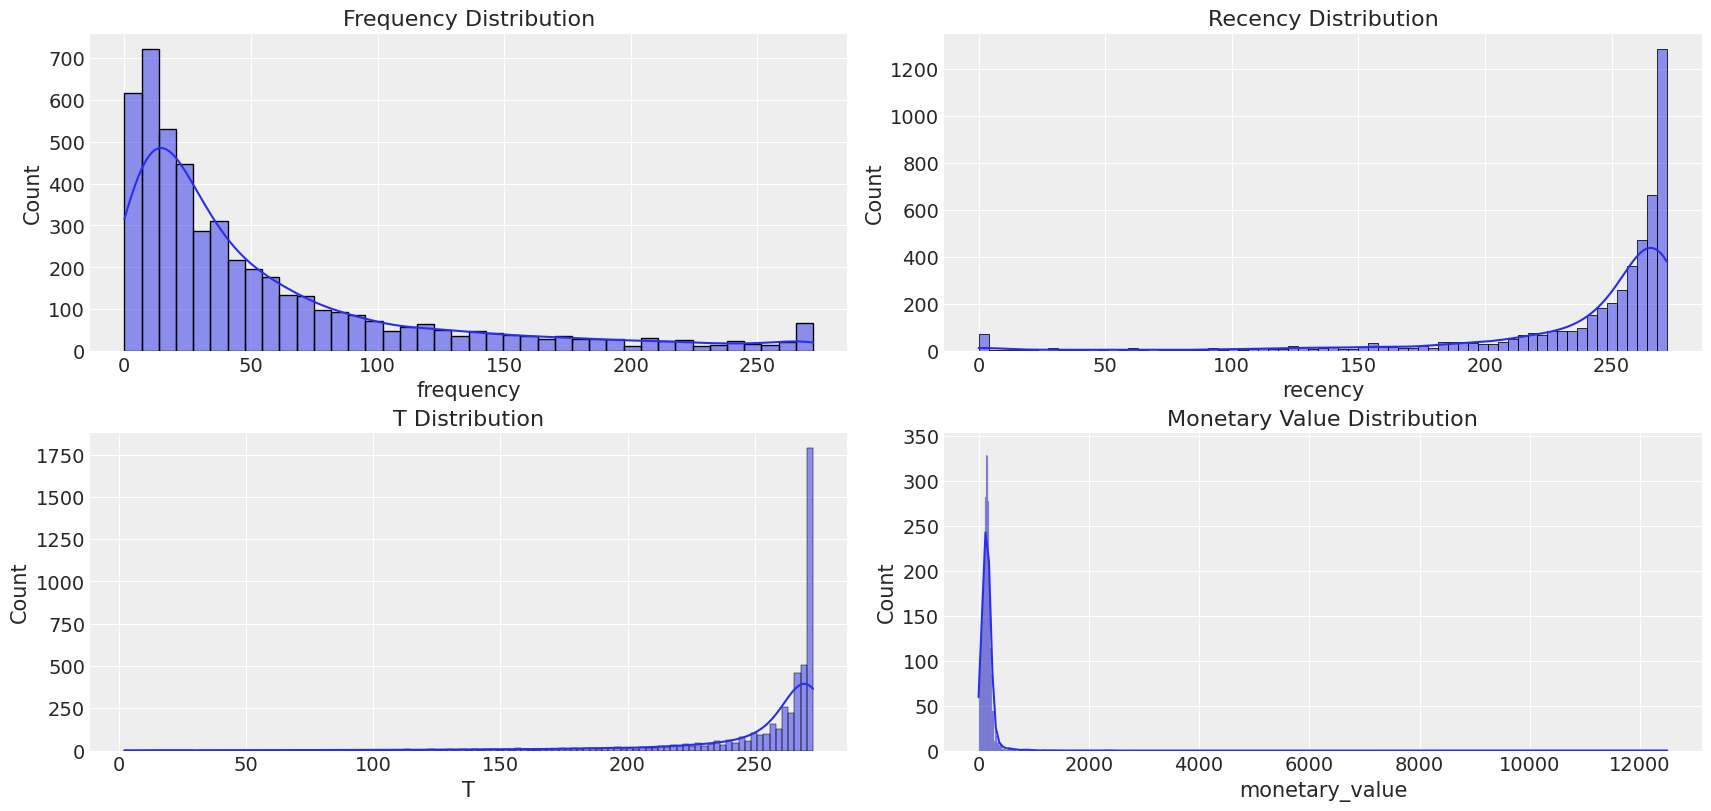

In [102]:
fig, axes = plt.subplots(2, 2, figsize=(17, 8))

# Plot histograms
sns.histplot(train_data["frequency"], kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Frequency Distribution")

sns.histplot(train_data["recency"], kde=True, ax=axes[0, 1])
axes[0, 1].set_title("Recency Distribution")

sns.histplot(train_data["T"], kde=True, ax=axes[1, 0])
axes[1, 0].set_title("T Distribution")

sns.histplot(train_data["monetary_value"], kde=True, ax=axes[1, 1])
axes[1, 1].set_title("Monetary Value Distribution")

plt.show();

### Summary Statistics

In [103]:
with pd.option_context("display.float_format", "{:,.2f}".format):
    print(train_data.describe())

       frequency  recency        T  monetary_value
count   4,961.00 4,961.00 4,961.00        4,961.00
mean       55.04   238.52   250.73          161.56
std        62.19    53.91    41.17          249.08
min         0.00     0.00     2.00            0.00
25%        12.00   235.00   251.00           97.32
50%        31.00   260.00   268.00          144.81
75%        71.00   269.00   272.00          185.16
max       272.00   272.00   273.00       12,493.76


### Correlation Heatmap

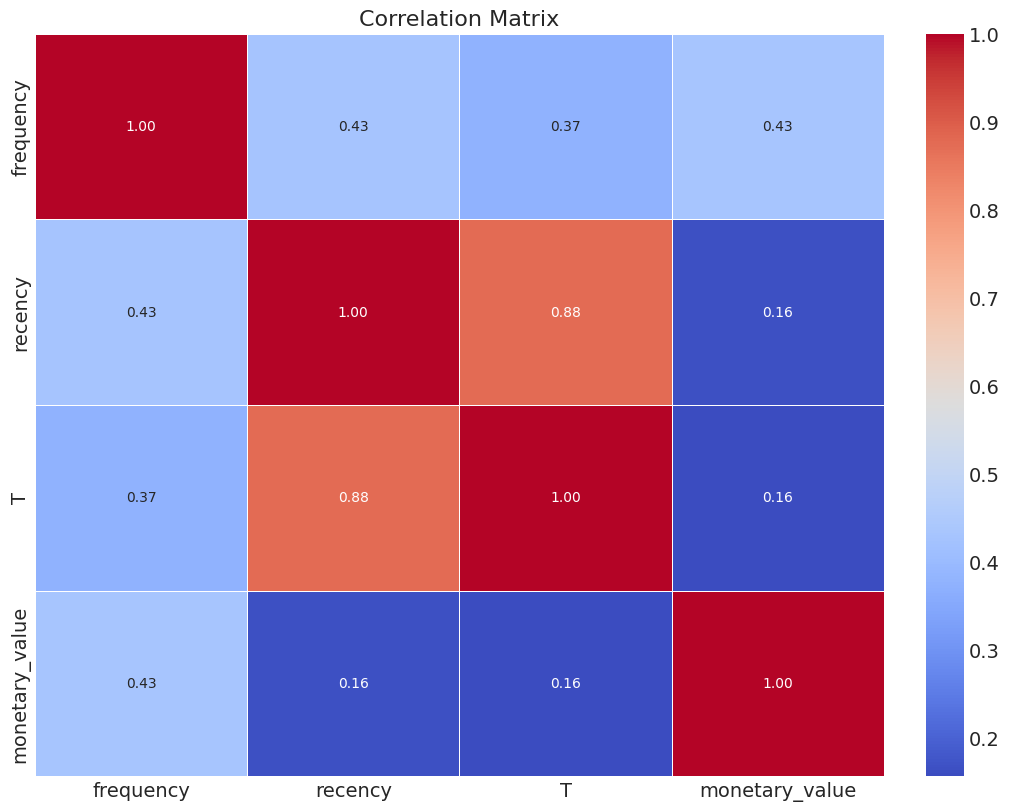

In [104]:
correlation_matrix = train_data[["frequency", "recency", "T", "monetary_value"]].corr(
    method="pearson"
)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, ax=ax
)
plt.title("Correlation Matrix")
plt.show();

## Bull-Till-You-Die (BTYD) Model Definition

The Pareto/NBD model is based on the following assumptions for each customer:

1. Customers are active for an unobserved period of time, then become permanently inactive.

### Purchasing Process

2. While active, the the number of transactions made by a customer follows a Poisson process with transaction rate $\lambda$ :

    $$
    P(X(t)=x \mid \lambda)=\frac{(\lambda t)^x e^{-\lambda t}}{x!}, x=0,1,2, \ldots
    $$


    This is equivalent to assuming time between transactions is exponentially distributed with transaction rate $\lambda$:

    $$
    f\left(t_j-t_{j-1} \mid \lambda\right)=\lambda e^{-\lambda\left(t_j-t_{j-1}\right)}, \quad t_j \geq t_{j-1} \geq 0
    $$

    Where $t$ is the time period of the $j$ th purchase.

3. Heterogeneity in $\lambda$ follows a Gamma distribution with shape parameter $r$ and scale parameter $\alpha$ :

    $$
    g(\lambda \mid r, \alpha)=\frac{\alpha^r \lambda^{r-1} e^{-\lambda \alpha}}{\Gamma(r)}
    $$

### Dropout Process

4. The duration of a customer's unobserved active lifetime is exponentially distributed with dropout rate $\mu$.

5. Heterogeneity in $\mu$ also follows a Gamma distribution with shape parameter $s$ and scale parameter $\beta$ :

    $$
    g(\mu \mid s, \beta)=\frac{\beta^s \mu^{s-1} e^{-\mu \beta}}{\Gamma(s)}
    $$

6. Transaction rate $\lambda$ and time until dropout $\mu$ vary independently for each customer.

If we take the expectation across the distributions of $\lambda$ and $\mu$, we can derive a likelihood function to estimate parameters $r, \alpha, s$, and $\beta$ across the customer population. For more details on the ParetoNBD likelihood please refer to the docs.

### Prior Specifications

Below is practical workflow to **use the data itself** (frequency, recency, T) to **inform the hyperparameters (i.e. the shape/scale)** of our Pareto/NBD priors. This approach—sometimes called *empirical Bayes* or a *moment-matching* strategy—helps ensure the priors start in a “reasonable” region of parameter space rather than being purely guesswork.

#### Using Frequentist Estimates

1. **Fit a frequentist Pareto/NBD** model with `lifetimes.ParetoNBDFitter` to the RFM data:

   - `frequency`: total number of repeat purchases for each customer  
   - `recency`: time between first purchase and last purchase  
   - `T`: time from first purchase until end of observation window  

2. **Extract the MLE parameters** $(r, \alpha, s, \beta)$ from `pnbd_lt.params_`, which is an `OrderedDict`:

   - $\lambda \sim \Gamma(r, \alpha)$ for purchase behavior (with $\alpha$ as **rate**)
   - $\mu \sim \Gamma(s, \beta)$ for dropout behavior (with $\beta$ as **rate**)

3. **Map MLE estimates into Bayesian priors**: In `pymc_marketing`, a typical parameterization for `Prior("Gamma", alpha=?, beta=?)` expects `alpha=?` as the **shape** and `beta=?` as the **rate**.  
   - We can directly set `r_prior = Prior("Gamma", alpha=r_mle, beta=alpha_mle)` and `s_prior = Prior("Gamma", alpha=s_mle, beta=beta_mle)` to reflect the MLE shape and rate.  
   - We can either use those MLE rates for `alpha_prior` and `beta_prior` as well, or keep simpler “fallback” defaults like `Gamma(2.0, 0.2)` if we want to allow more prior uncertainty.

With this approach, the Bayesian model starts near the frequentist MLE solution, which often stabilizes inference and improves predictive performance—particularly on smaller datasets or when data is not overly abundant.

In [186]:
model_config_mle_btyd: Dict[str, Prior] = create_btyd_model_config_mle(
    rfm_data=train_data,
    use_mle_for_alpha_beta=False,
)

model_config_mle_btyd

{'r_prior': Prior("Gamma", alpha=0.9994459204042974, beta=4.8290793310785824),
 'alpha_prior': Prior("Gamma", alpha=2.0, beta=0.2),
 's_prior': Prior("Gamma", alpha=2.373684806241492e-09, beta=269.1410153020359),
 'beta_prior': Prior("Gamma", alpha=2.0, beta=0.2)}

### Maximum Likelihood Estimates (MLE)

For a Gamma distribution, the mean is given by:

$$
\text{Mean} = \frac{\text{shape}}{\text{rate}} = \text{shape} \times \text{scale}
$$

So, the MLEs for $\lambda$ and $\mu$ based on the priors would be their expected values (means):

1. **Expected Transaction Rate ($\mathbb{E}[\lambda]$)**:
   $$
   \mathbb{E}[\lambda] = \frac{r}{\alpha}
   $$

2. **Expected Dropout Rate ($\mathbb{E}[\mu]$)**:
   $$
   \mathbb{E}[\mu] = \frac{s}{\beta}
   $$

In [187]:
# Gamma parameters for the lambda prior
alpha_r_prior: float = model_config_mle_btyd["r_prior"].parameters["alpha"]
beta_r_prior: float = model_config_mle_btyd["r_prior"].parameters["beta"]

alpha_alpha_prior: float = model_config_mle_btyd["alpha_prior"].parameters["alpha"]
beta_alpha_prior: float = model_config_mle_btyd["alpha_prior"].parameters["beta"]

# Gamma parameters for the mu prior
alpha_s_prior: float = model_config_mle_btyd["s_prior"].parameters["alpha"]
beta_s_prior: float = model_config_mle_btyd["s_prior"].parameters["beta"]

alpha_beta_prior: float = model_config_mle_btyd["beta_prior"].parameters["alpha"]
beta_beta_prior: float = model_config_mle_btyd["beta_prior"].parameters["beta"]

In [188]:
expected_r: float = alpha_r_prior / beta_r_prior
expected_alpha: float = alpha_alpha_prior / beta_alpha_prior

expected_s: float = alpha_s_prior / beta_s_prior
expected_beta: float = alpha_beta_prior / beta_beta_prior

expected_lambda: float = expected_r / expected_alpha
expected_mu: float = expected_s / expected_beta

print(f"Expected Lambda: {expected_lambda:.2f} per time unit")
print(f"Expected Mu: {expected_mu} per time unit")

Expected Lambda: 0.02 per time unit
Expected Mu: 8.819483732636184e-13 per time unit


This implies that, under these priors, account holders are expected to make transactions at a rate of approximately $x$ per time unit, while the dropout rate is extremely low, suggesting that customers tend to remain active for a long time.

### Predictive Checks

#### Bayes Theorem

Bayes' theorem provides us with a general recipe to estimate the value of the parameter $\boldsymbol{\theta}$ given that we have observed some data $\boldsymbol{Y}$:

$$
\underbrace{p(\boldsymbol{\theta} \mid \boldsymbol{Y})}_{\text {posterior }}=\frac{\overbrace{p(\boldsymbol{Y} \mid \boldsymbol{\theta})}^{\text {likelihood }} \overbrace{p(\boldsymbol{\theta})}^{\text {prior }}}{\underbrace{p(\boldsymbol{Y})}_{\text {marginal likelihood }}}
$$


The likelihood function links the observed data with the unknown parameters while the prior distribution represents the uncertainty about the parameters before observing the data $\boldsymbol{Y}$. By multiplying them we obtain the posterior distribution, that is the joint distribution over all the parameters in the model (conditioned on the observed data).

#### Prior

The prior predictive distribution:

$$
p\left(\boldsymbol{Y}^*\right)=\int_{\boldsymbol{\Theta}} p\left(\boldsymbol{Y}^* \mid \boldsymbol{\theta}\right) p(\boldsymbol{\theta}) d \boldsymbol{\theta}
$$


This is the expected distribution of the data according to the model (prior and likelihood). That is the data we expect, given the model, before actually seeing any observed data $Y^*$.

#### Posterior

The posterior predictive distribution:

$$
p(\tilde{\boldsymbol{Y}} \mid \boldsymbol{Y})=\int_{\boldsymbol{\Theta}} p(\tilde{\boldsymbol{Y}} \mid \boldsymbol{\theta}) p(\boldsymbol{\theta} \mid \boldsymbol{Y}) d \boldsymbol{\theta}
$$


This is the distribution of expected, future, data $\tilde{\boldsymbol{Y}}$ according to the posterior $p(\boldsymbol{\theta} \mid \boldsymbol{Y})$, which in turn is a consequence of the model (prior and likelihood) and observed data. In more common terms, this is the data the model is expecting to see after seeing the dataset $\boldsymbol{Y}$, i.e. these are the model's predictions. From the equation, we can see that predictions are computed by integrating out (or marginalizing) over the posterior distribution of parameters. As a consequence predictions computed this way will incorporate the uncertainty about parameter estimation.

In [108]:
max_purchases: int = int(train_data["frequency"].max())
max_purchases

272

Sampling: [alpha, beta, r, recency_frequency, s]
/Users/yang_wu/pyapp/credit_card_clv/.venv/lib/python3.12/site-packages/pymc_marketing/clv/distributions.py:295: RuntimeWarning: divide by zero encountered in scalar divide
  dropout_time = rng.exponential(scale=1 / mu)
/Users/yang_wu/pyapp/credit_card_clv/.venv/lib/python3.12/site-packages/pymc_marketing/clv/distributions.py:296: RuntimeWarning: divide by zero encountered in scalar divide
  wait = rng.exponential(scale=1 / lam)
/Users/yang_wu/pyapp/credit_card_clv/.venv/lib/python3.12/site-packages/pymc_marketing/clv/distributions.py:296: RuntimeWarning: overflow encountered in scalar divide
  wait = rng.exponential(scale=1 / lam)
Multiprocess sampling (4 chains in 4 jobs)
DEMetropolisZ: [alpha, beta, r, s]


Output()

/Users/yang_wu/pyapp/credit_card_clv/.venv/lib/python3.12/site-packages/pymc/step_methods/metropolis.py:1194: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),


/Users/yang_wu/pyapp/credit_card_clv/.venv/lib/python3.12/site-packages/pymc/step_methods/metropolis.py:1194: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/Users/yang_wu/pyapp/credit_card_clv/.venv/lib/python3.12/site-packages/pymc/step_methods/metropolis.py:1194: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/Users/yang_wu/pyapp/credit_card_clv/.venv/lib/python3.12/site-packages/pymc/step_methods/metropolis.py:1194: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),


Sampling 4 chains for 5_800 tune and 5_300 draw iterations (23_200 + 21_200 draws total) took 13 seconds.
Sampling: [recency_frequency]


Output()

/Users/yang_wu/pyapp/credit_card_clv/.venv/lib/python3.12/site-packages/pymc_marketing/clv/distributions.py:295: 
RuntimeWarning: divide by zero encountered in scalar divide
  dropout_time = rng.exponential(scale=1 / mu)

/Users/yang_wu/pyapp/credit_card_clv/.venv/lib/python3.12/site-packages/pymc_marketing/clv/distributions.py:295: 
RuntimeWarning: overflow encountered in scalar divide
  dropout_time = rng.exponential(scale=1 / mu)

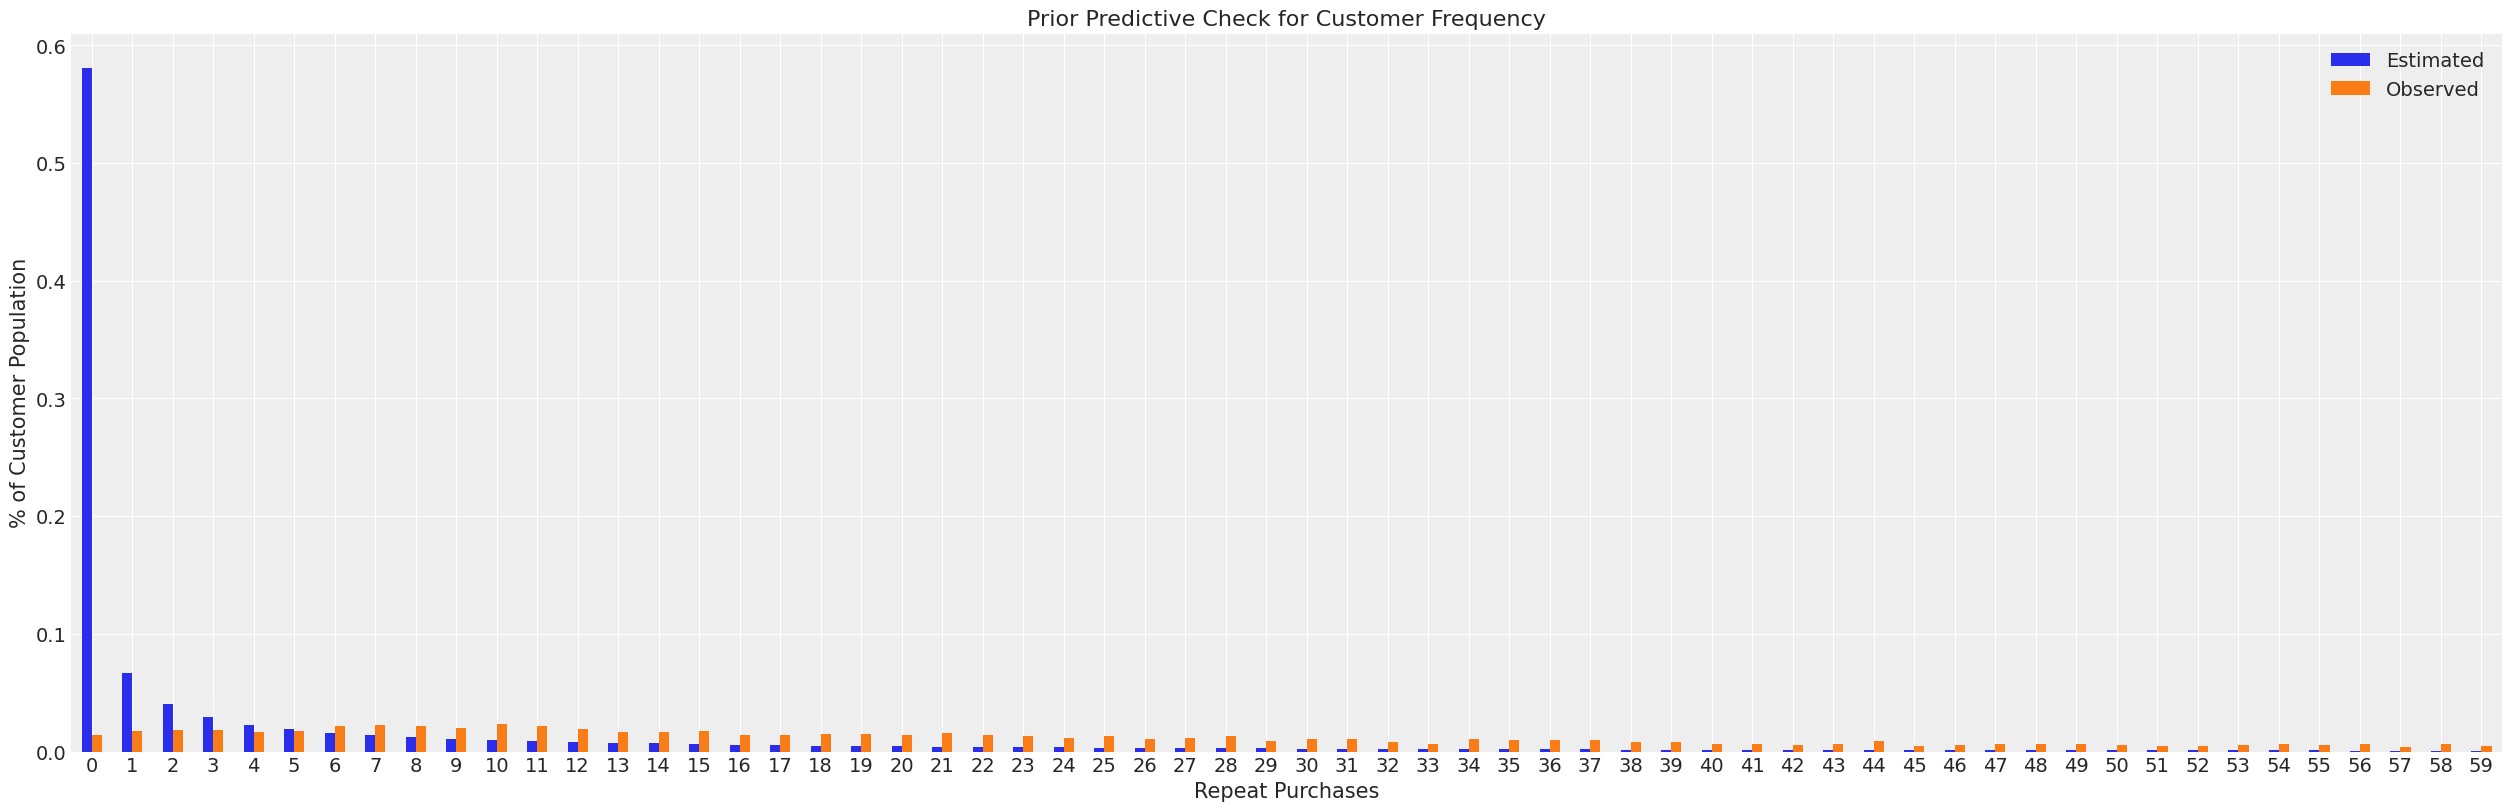

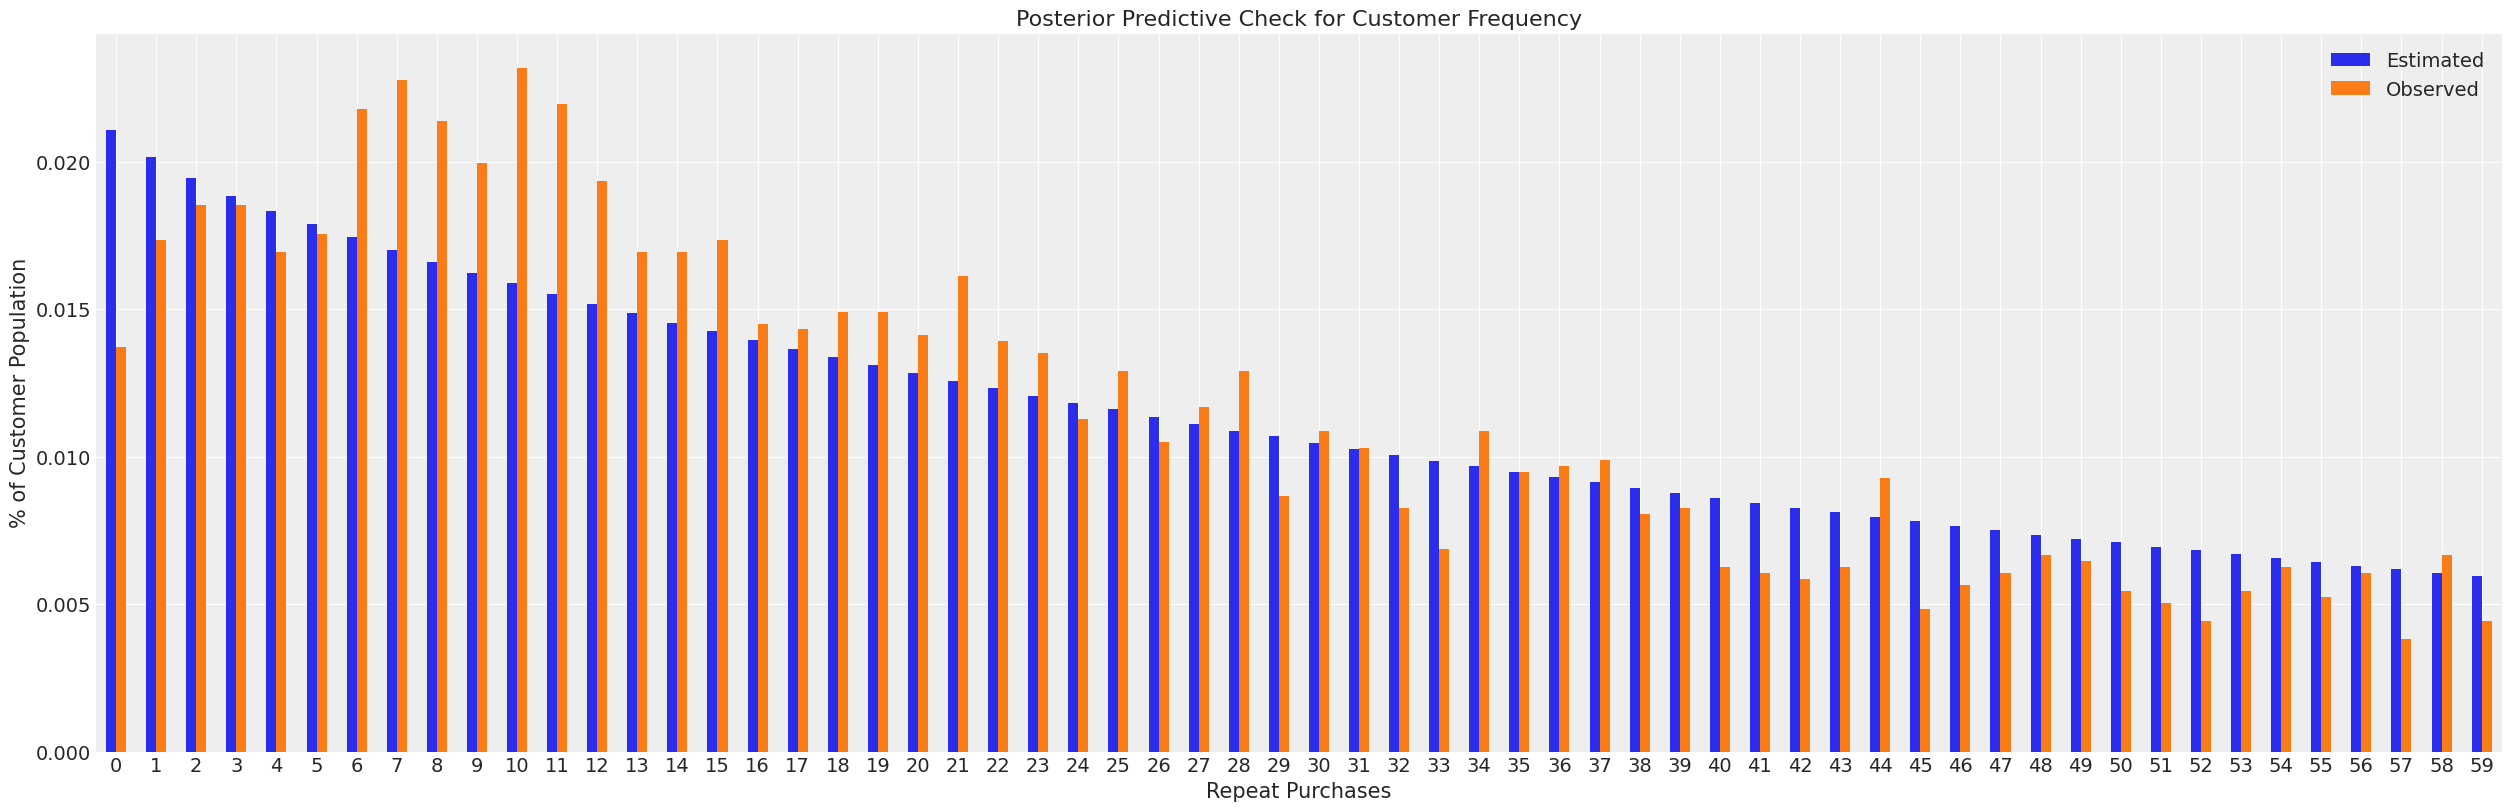

In [109]:
pnbd_model, prior_check, posterior_check = run_pnbd_ppcs(
    rfm_data=train_data.loc[:, ["customer_id", "frequency", "recency", "T"]],
    model_config=model_config_mle_btyd,
    fit_method="demz",
    prior_samples=1000,
    max_purchases=60,
    random_seed=random_state,
    draws=5300,
    tune=5800,
    fig_size=(25, 8),
    idata_kwargs={"log_likelihood": True},
)

Persist model:

In [111]:
for group in pnbd_model.idata.groups():
    print(f"Group: {group}")
    ds = pnbd_model.idata[group]
    for var in ds.data_vars:
        print(f"  Variable: {var}, dtype: {ds[var].dtype}")

pnbd_model.idata.fit_data["customer_id"] = pnbd_model.idata.fit_data[
    "customer_id"
].astype("U")

Group: posterior
  Variable: alpha, dtype: float64
  Variable: beta, dtype: float64
  Variable: r, dtype: float64
  Variable: s, dtype: float64
Group: log_likelihood
  Variable: recency_frequency, dtype: float64
Group: sample_stats
  Variable: lambda, dtype: float64
  Variable: accept, dtype: float64
  Variable: accepted, dtype: bool
  Variable: scaling, dtype: float64
Group: observed_data
  Variable: recency_frequency, dtype: float64
Group: fit_data
  Variable: customer_id, dtype: <U9
  Variable: frequency, dtype: float64
  Variable: recency, dtype: float64
  Variable: T, dtype: float64


Keep every 10th draw to reduce the memory requirements:

In [112]:
pnbd_model.save(str(model_path / f"pnbd_model_full.nc"))

for keep_every in [20, 50]:
    thin_model: ParetoNBDModel = pnbd_model.thin_fit_result(keep_every=keep_every)

    thin_model.save(str(model_path / f"pnbd_model_thin_{keep_every}.nc"))

In [113]:
pnbd_model = pnbd_model.thin_fit_result(keep_every=20)

### Model Trace

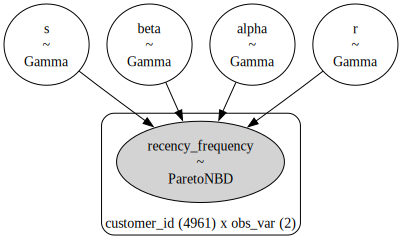

In [114]:
pnbd_model.graphviz()

#### Convergence and Efficiency Diagnostics for Markov Chains

[Source](https://mc-stan.org/rstan/reference/Rhat.html)

- **Mean**  

  - **Definition:** The average value of the posterior samples for a parameter.  
  - **Importance:** Provides a point estimate of the parameter’s central tendency.

- **SD (Standard Deviation)**  

  - **Definition:** Measures the spread or dispersion of the posterior samples around the mean.  
  - **Importance:** Indicates uncertainty in the parameter estimate.

- **HDI (Highest Density Interval) [hdi_3% and hdi_97%]**  

  - **Definition:** The interval within which the parameter value falls with a high probability (here, approximately a 94% interval from the 3rd to the 97th percentile).  
  - **Importance:** Shows the range of credible values for the parameter, helping assess estimation precision.

- **MCSE (Monte Carlo Standard Error) [mcse_mean and mcse_sd]**  

  - **Definition:** The standard error associated with the Monte Carlo estimates of the mean and standard deviation.  
  - **Importance:** Quantifies the sampling variability due to the finite number of draws; low values suggest that the estimates are reliable.

- **ESS (Effective Sample Size) [ess_bulk and ess_tail]**  

  - **Definition:**  

    - **Bulk ESS:** Reflects the effective number of independent samples in the central region of the distribution (affecting estimates like the mean and median).  
    - **Tail ESS:** Reflects the effective number of independent samples in the tails of the distribution (affecting estimates such as quantiles or variance).  
  - **Importance:** High ESS values (a rough rule of thumb is at least 100 per chain) indicate that the sampling was efficient and that the estimates of posterior quantities are reliable.

- **R-hat**  

  - **Definition:** A convergence diagnostic that compares the variance between chains with the variance within chains.  
  - **Importance:** An R-hat value close to 1 (commonly below 1.05) suggests that multiple chains have converged to the same distribution, ensuring reliable posterior inference.


In [115]:
pnbd_model.fit_summary()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,4.825,0.111,4.609,5.025,0.003,0.002,1006.0,943.0,1.0
beta,9.770,7.098,0.589,23.109,0.230,0.163,906.0,1016.0,1.0
r,0.999,0.018,0.965,1.034,0.001,0.000,809.0,819.0,1.0
s,0.000,0.000,0.000,0.000,0.000,0.000,831.0,870.0,1.0


#### Trace Plot

- **Model Object (`pnbd_model`):** The variable `pnbd_model` contains the results of fitting a Pareto/NBD model using Markov Chain Monte Carlo (MCMC) techniques. This object stores posterior samples for the model parameters, which are used for diagnostic purposes and further analysis.

- **MCMC Chains (Y-Axis: Chain 0 to 3):** The plot displays multiple independent chains, labeled 0 through 3. Each chain represents a separate sequence of samples generated during the MCMC simulation. Independent chains are used to ensure that the sampling process converges to the same target distribution regardless of the starting values. Consistency across these chains is an indication that the sampling process is robust and the model is converging well.

- **Rank Bars (X-Axis: Rank 0 to 1000):** In this visualization, the "rank" of a sample refers to its position in an ordered list when the samples from a single chain are sorted by their value. The x-axis shows these ranks, which in this case range from 0 to 1000, representing the positions of approximately 1000 samples per chain.
  
  - **Even Ranks:** When the rank bars appear even and uniformly distributed across the range, it suggests that the samples from the chain are well mixed. This uniformity indicates that the chain has adequately explored the parameter space, and that the distribution of samples is smooth. In essence, evenly spaced rank bars are an indicator of successful convergence and reliable sampling.

  - **Uneven Ranks:** If the rank bars show irregularities or clustering (i.e., uneven distribution), it could signal issues with mixing within the chain. An uneven rank distribution might reveal that the chain is stuck in certain regions of the parameter space or has not fully converged to the target distribution. Such behavior may necessitate additional diagnostic checks or adjustments to the sampling process (e.g., increasing the number of iterations, adjusting tuning parameters, or reconsidering the model specification).

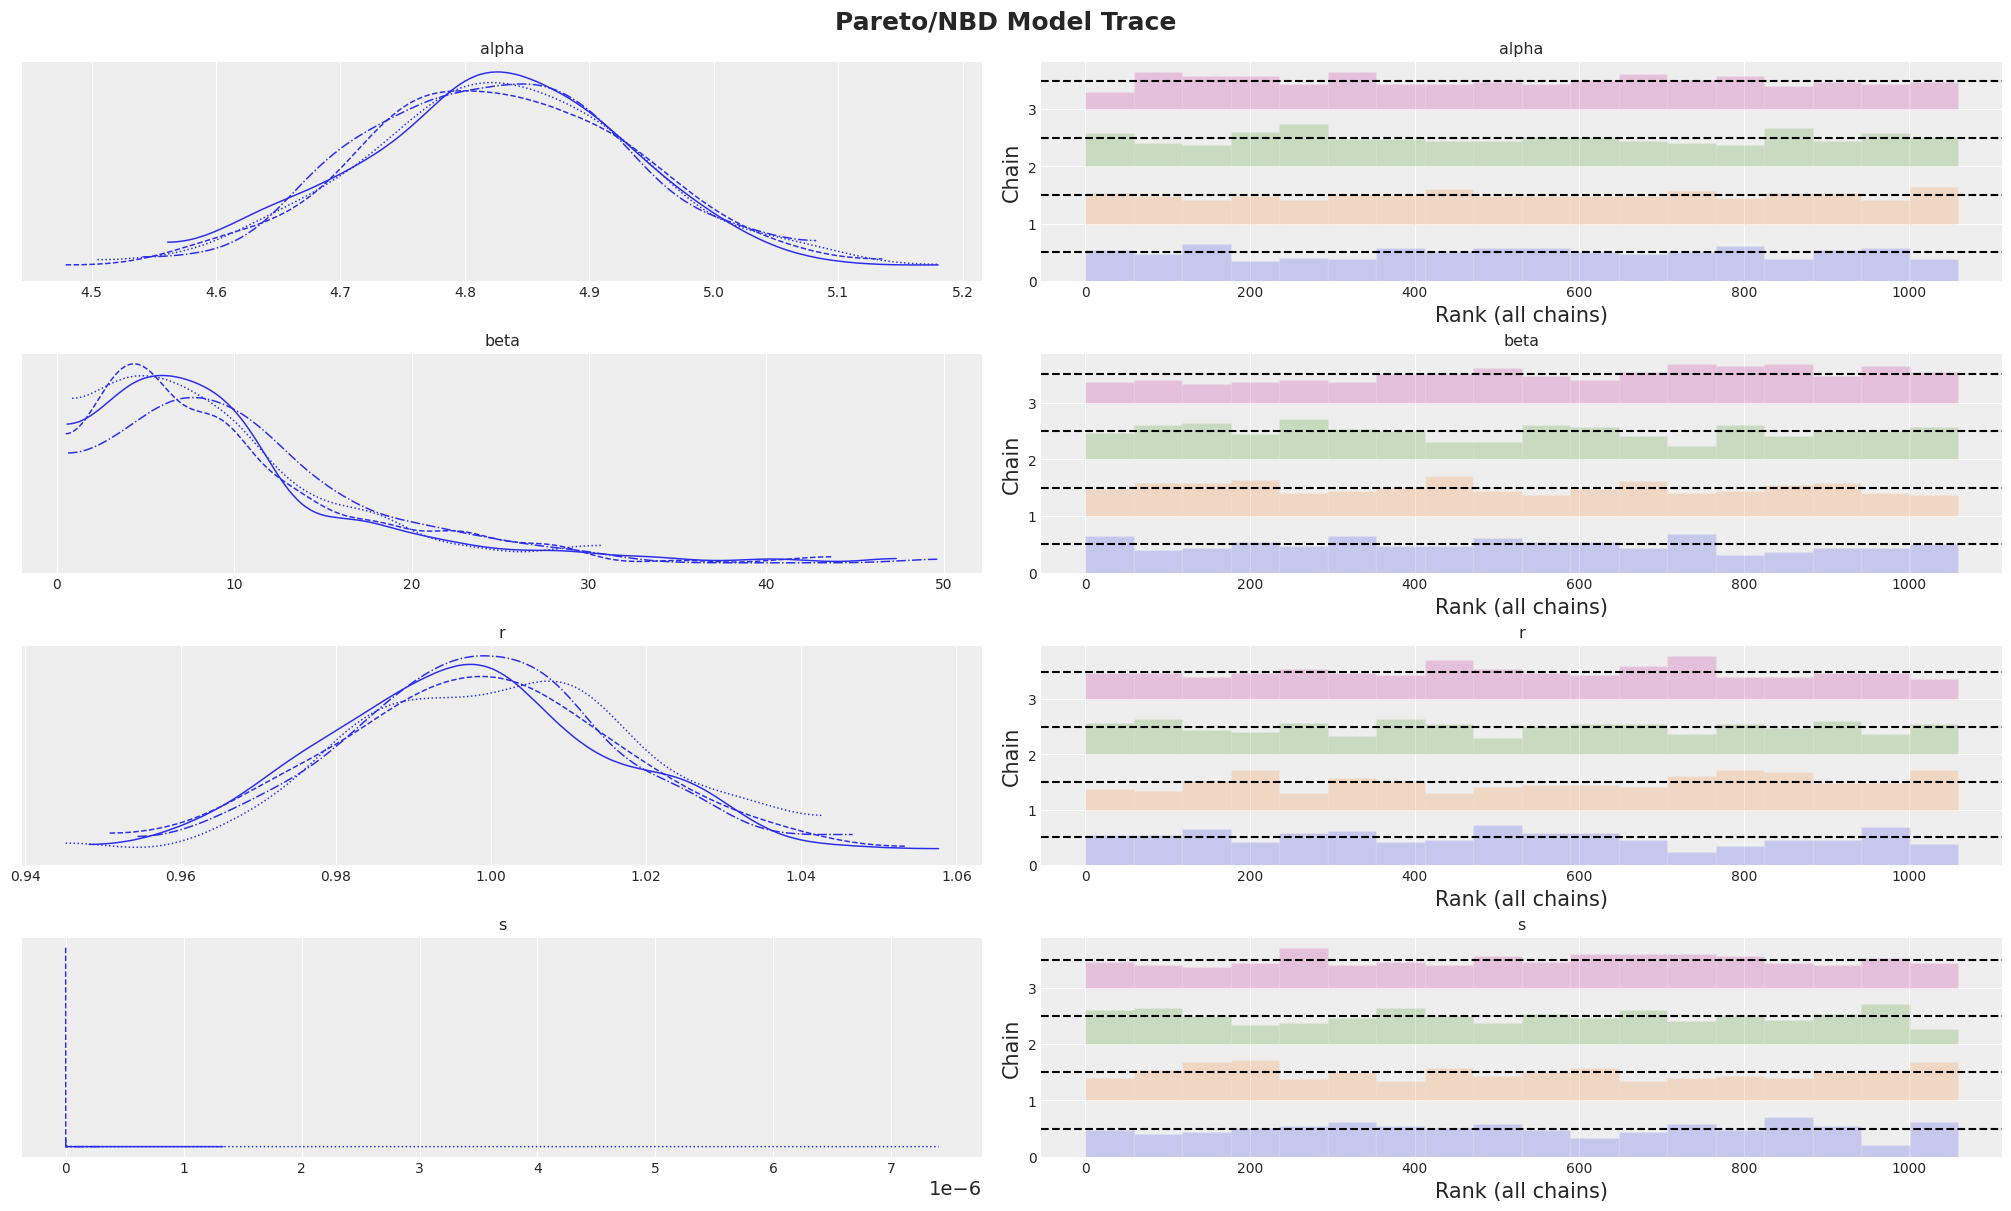

In [116]:
axes = az.plot_trace(
    data=pnbd_model.idata,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (20, 12), "layout": "constrained"},
)
plt.gcf().suptitle("Pareto/NBD Model Trace", fontsize=18, fontweight="bold");

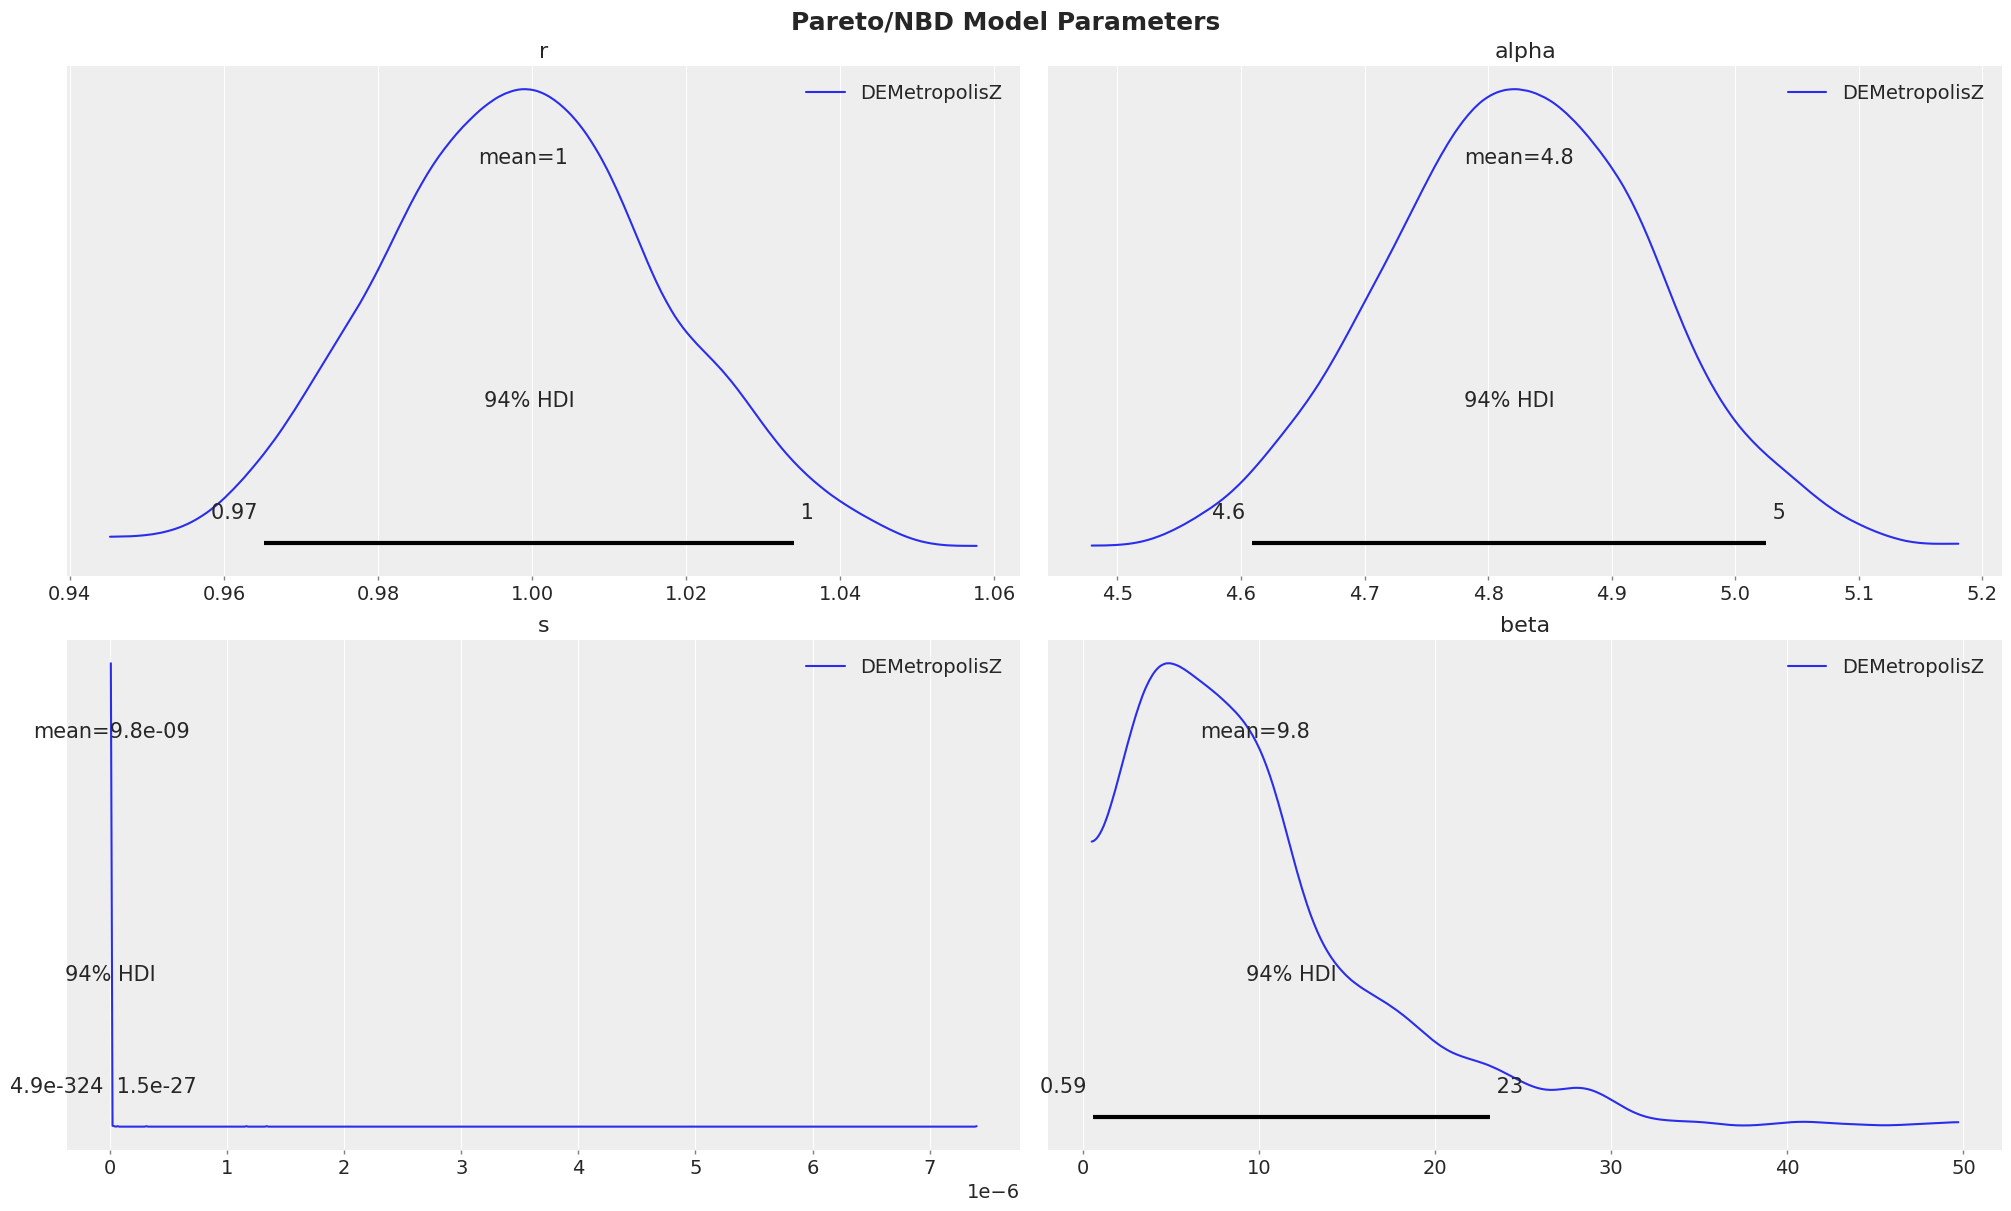

In [117]:
_, axes = plt.subplots(
    nrows=2, ncols=2, figsize=(20, 12), sharex=False, sharey=False, layout="constrained"
)
axes = axes.flatten()

for i, var_name in enumerate(["r", "alpha", "s", "beta"]):
    ax = axes[i]
    az.plot_posterior(
        pnbd_model.idata.posterior[var_name].values.flatten(),
        color="C0",
        point_estimate="mean",
        ax=ax,
        label="DEMetropolisZ",
    )
    ax.legend(loc="upper right")
    ax.set_title(var_name)

plt.gcf().suptitle("Pareto/NBD Model Parameters", fontsize=18, fontweight="bold");

### Expected Transactions Over Time

#### Validation Period

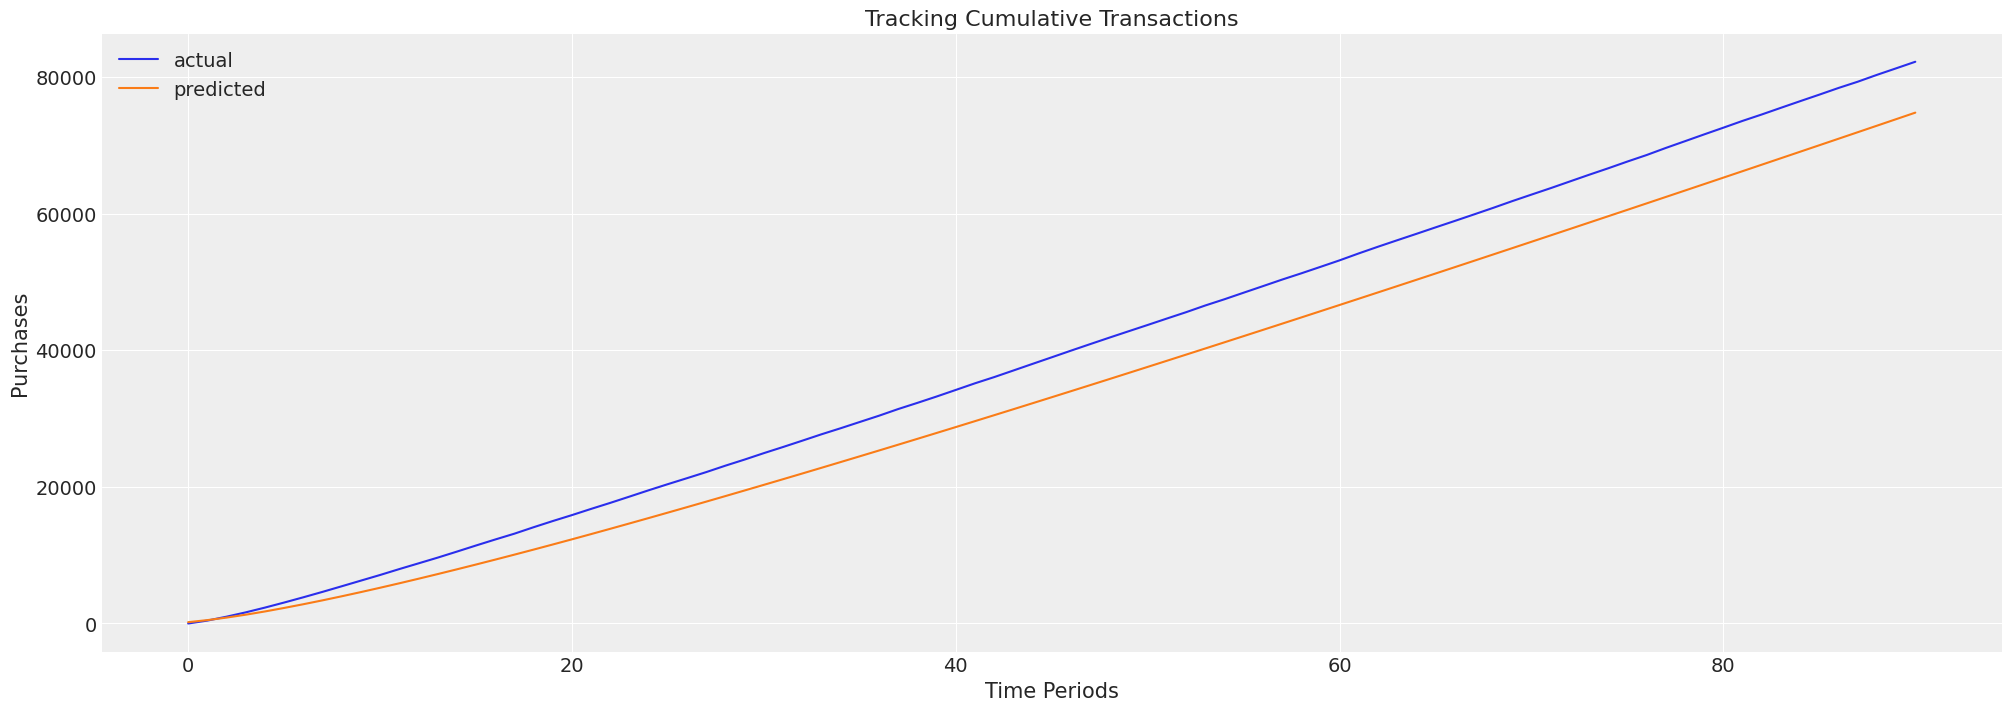

In [118]:
future_t_val: int = (
    pd.to_datetime(validation_period_end) - pd.to_datetime(train_period_end)
).days

plot_expected_purchases_over_time(
    model=pnbd_model,
    purchase_history=data.loc[data["transaction_datetime"] <= train_period_end],
    customer_id_col="account_number",
    datetime_col="transaction_datetime",
    time_unit="D",
    t=future_t_val,
    figsize=(20, 7),
)
plt.show();

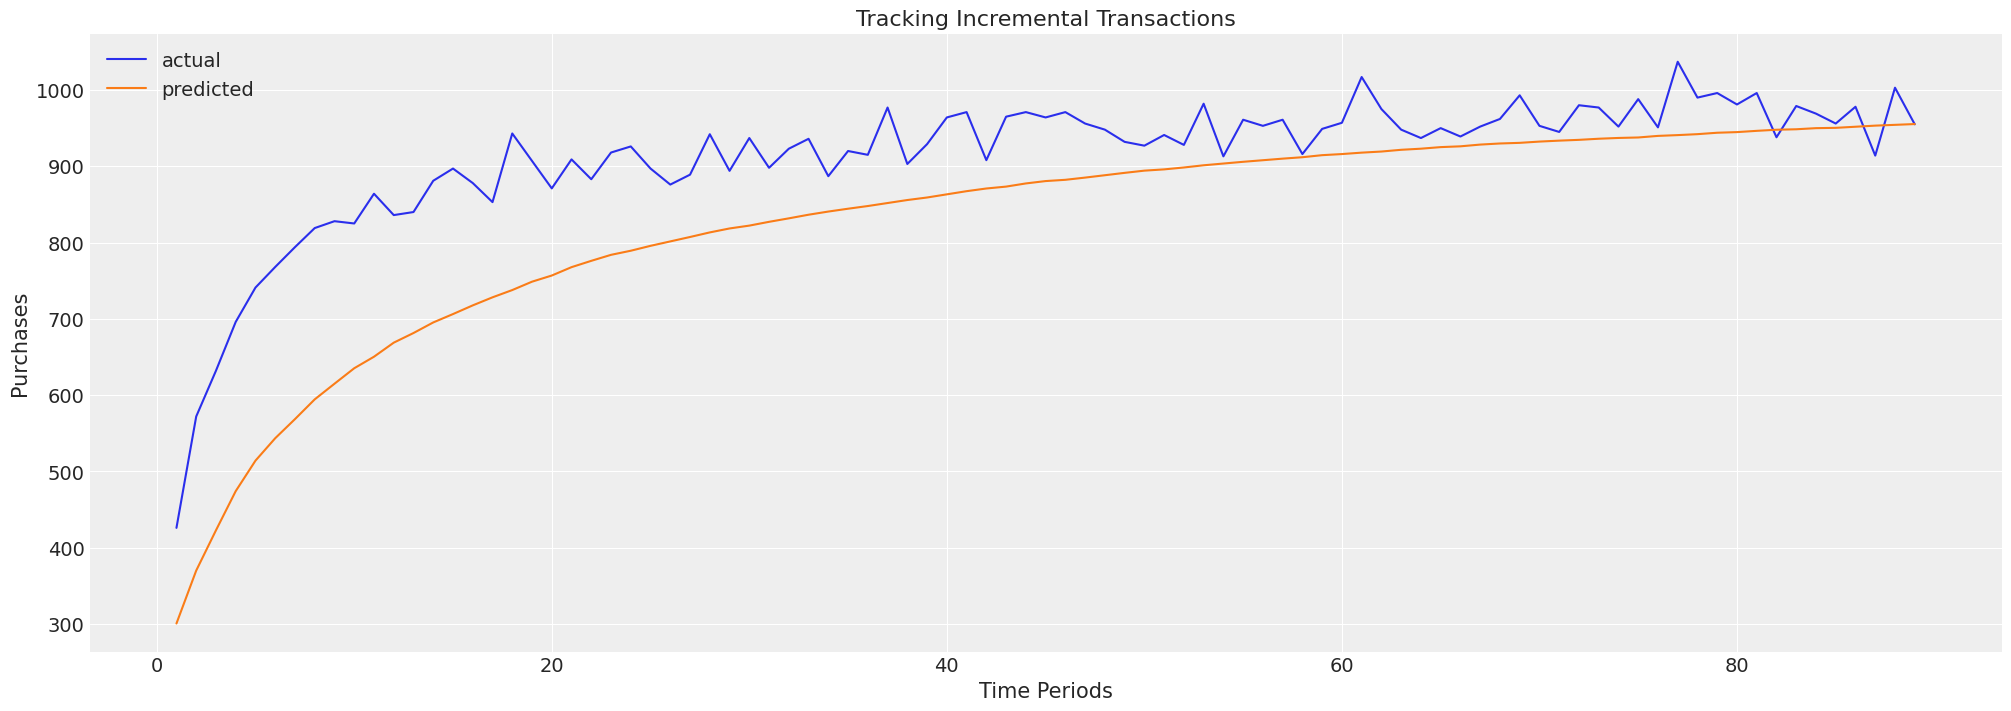

In [119]:
plot_expected_purchases_over_time(
    model=pnbd_model,
    purchase_history=data,
    customer_id_col="account_number",
    datetime_col="transaction_datetime",
    time_unit="D",
    t=90,
    figsize=(20, 7),
    plot_cumulative=False,
)
plt.show();

### Expected Number of Purchases

#### Validation Period

In [363]:
expected_purchases_val: DataArray = pnbd_model.expected_purchases(future_t=future_t_val)

validation_data["expected_purchases"] = expected_purchases_val.mean(
    dim=("chain", "draw")
).values

In [364]:
validation_data

,customer_id,test_frequency,test_T,test_monetary_value,expected_purchases
0,100088067,19.0,91.0,105.290001,16.028833
1,100108752,6.0,91.0,48.928333,7.239457
2,100328049,25.0,91.0,91.034004,20.420838
3,100663626,11.0,91.0,347.093628,6.161539
4,100737756,31.0,91.0,233.735168,32.472720
...,...,...,...,...,...
4956,999086814,76.0,91.0,360.098022,72.059412
4957,999257059,27.0,91.0,211.469635,32.687243
4958,999258704,23.0,91.0,85.534782,17.422175
4959,999283629,25.0,91.0,175.818802,29.806160


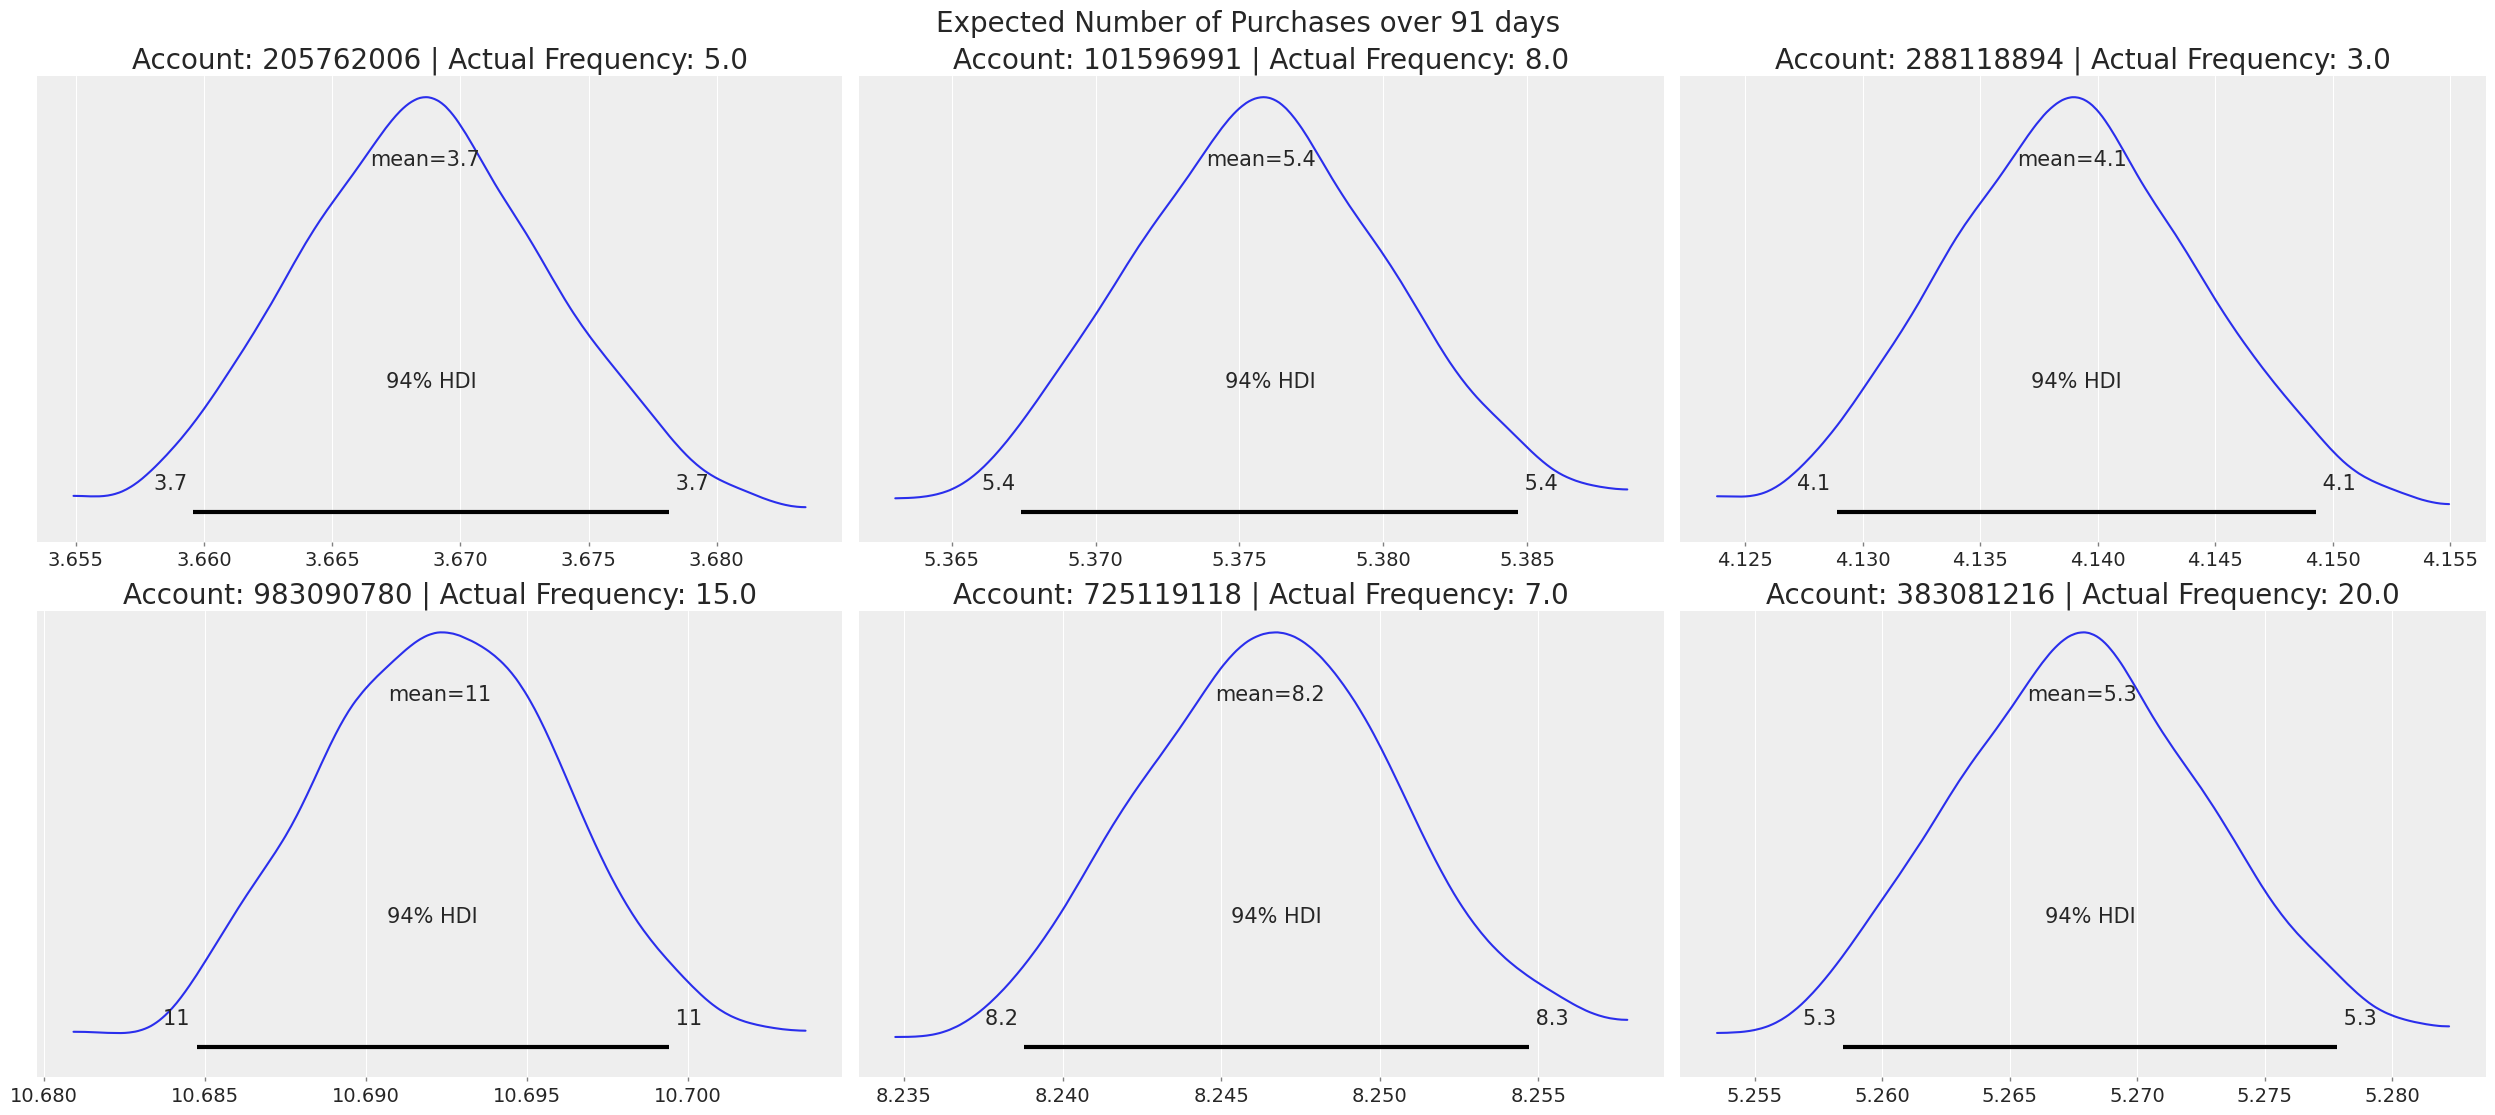

In [122]:
accounts: np.ndarray = rng.choice(
    validation_data["customer_id"].values, size=6, replace=False
)

ax = az.plot_posterior(expected_purchases_val.sel(customer_id=accounts), grid=(2, 3))

for axi, id in zip(ax.ravel(), accounts, strict=False):
    # Get the actual frequency for this customer_id
    actual_frequency = validation_data.loc[
        validation_data["customer_id"] == id, "test_frequency"
    ].values[0]
    # Set the title to include both expected purchases and the actual frequency observed during the validation period
    axi.set_title(f"Account: {id} | Actual Frequency: {actual_frequency}", size=20)

plt.suptitle(f"Expected Number of Purchases over {future_t_val} days", size=20);

In [123]:
validation_rmse: float = root_mean_squared_error(
    y_true=validation_data["test_frequency"],
    y_pred=validation_data["expected_purchases"],
)
validation_mae: float = mean_absolute_error(
    y_true=validation_data["test_frequency"],
    y_pred=validation_data["expected_purchases"],
)

print(f"Validation RMSE: {validation_rmse:.2f}")
print(f"Validation MAE: {validation_mae:.2f}")

Validation RMSE: 4.58
Validation MAE: 3.43


### Expected Number of Transactions For Any Specific Account

The two methods predict expected future purchases but for very different types of customers:

1. `expected_purchases` (Conditional on Customer History):

   - **Purpose:** This method predicts the expected number of future purchases for *existing* customers based on their past behavior. In other words, it is conditional on each customer’s observed history (their **frequency**, **recency**, and **T** — the total time observed).
     
   - **How It Works:**  
     - The method extracts the customer’s past data (frequency, recency, and T) along with any covariate information.
     - It then uses the fitted model parameters $(r, \alpha, s, \beta)$ and computes a log-likelihood (via the `_logp` helper) that reflects how well the parameters explain the observed history.
     - The prediction is computed using several terms (named `first_term`, `second_term`, and `third_term`) that involve gamma functions, logarithms, and exponentials. These terms come from the mathematical derivations (e.g., Equation (41) in Hardie’s notes) that adjust the prediction based on the customer’s transaction history.
     - Finally, the expected number of future purchases is obtained by exponentiating the sum of these terms and adjusting by the computed log-likelihood.
     
   - **Key Point:** Since it uses individual-specific data, the prediction is *conditional* on what the customer has already done. Customers with a long history of purchases (or a high frequency) will receive a different prediction than those with little or no history.

2. `expected_purchases_new_customer` (Unconditional for a New Customer):

   - **Purpose:** This method computes the expected number of purchases for a **new** customer over a specified time horizon. Here, “new” means that the customer has no past transactional history.
     
   - **How It Works:**  
     - The method extracts only the time horizon $t$ (specified via the argument `t` or from the provided data) along with the model parameters.
     - It does not use any customer history data such as frequency or recency.
     - The prediction is computed using a simpler formula:
       - **First term:** $\frac{r \times \beta}{\alpha \times (s-1)}$
       - **Second term:** $1 - \left(\frac{\beta}{\beta + t}\right)^{s-1}$
     - The product of these two terms (i.e. `first_term * second_term`) gives the expected number of purchases for a new customer over the time period $t$.
     
   - **Key Point:** This prediction is *unconditional* on any historical behavior. It is based solely on the overall (population-level) model parameters and the chosen time horizon. This is useful when we want to estimate behavior for a customer who has not yet made any purchases.

  0%|          | 0/91 [00:00<?, ?it/s]/Users/yang_wu/pyapp/credit_card_clv/.venv/lib/python3.12/site-packages/xarray/core/computation.py:824: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
100%|██████████| 91/91 [02:48<00:00,  1.85s/it]


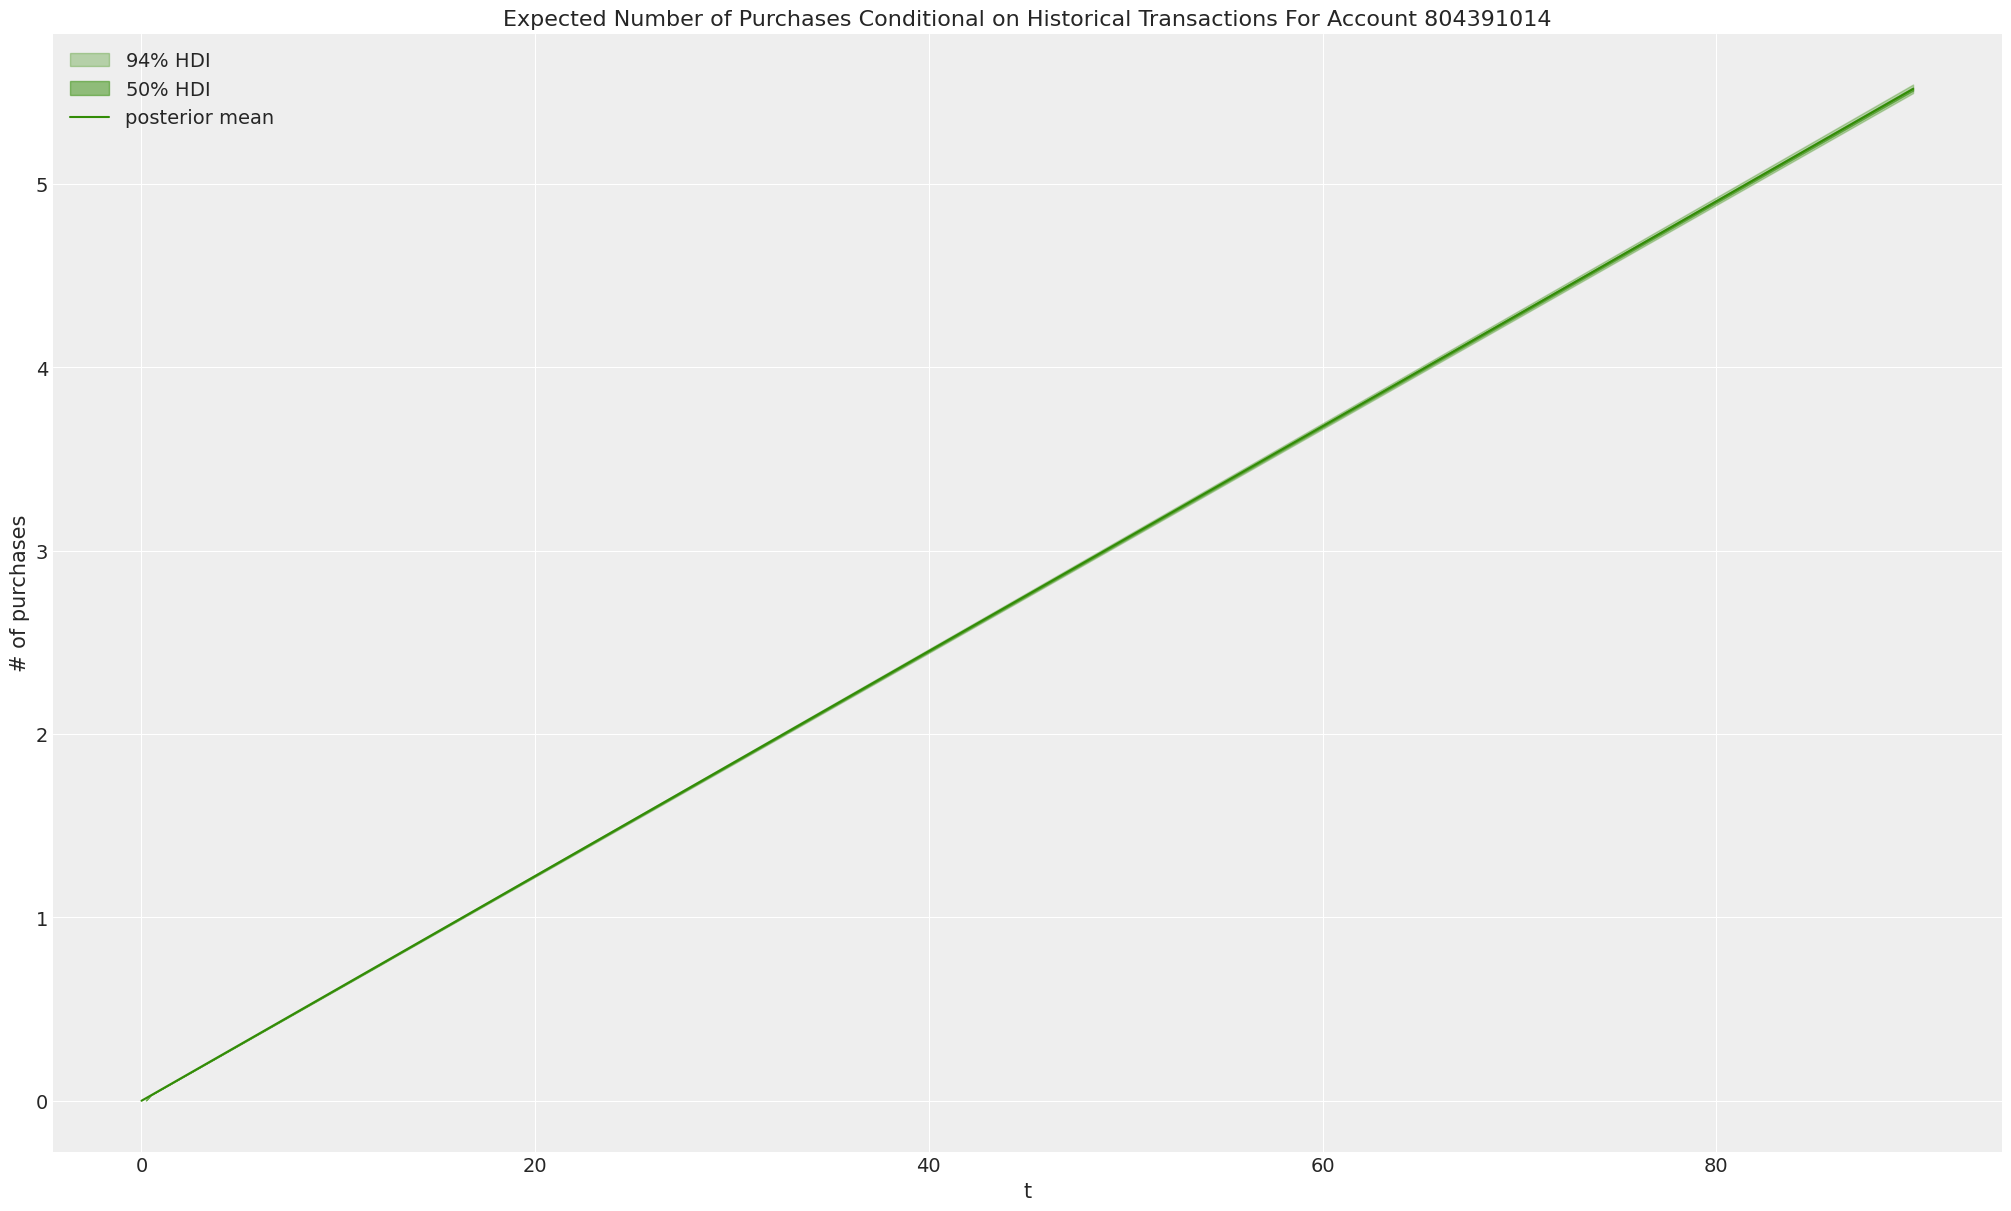

In [124]:
account_id: int = rng.choice(
    validation_data["customer_id"].values, size=1, replace=False
)[0]
t_range: range = range(future_t_val)

expected_purchases_conditional: DataArray = concat(
    objs=[
        pnbd_model.expected_purchases(
            data=train_data,
            future_t=t,
        ).sel(customer_id=account_id)
        for t in tqdm(t_range)
    ],
    dim="t",
).transpose(..., "t")

ax = plt.axes()
# Set the figure size
ax.figure.set_size_inches(20, 12)

az.plot_hdi(
    t_range,
    expected_purchases_conditional,
    hdi_prob=0.94,
    color="C2",
    fill_kwargs={"alpha": 0.3, "label": "$94 \\%$ HDI"},
    ax=ax,
)
az.plot_hdi(
    t_range,
    expected_purchases_conditional,
    hdi_prob=0.5,
    color="C2",
    fill_kwargs={"alpha": 0.5, "label": "$50 \\%$ HDI"},
    ax=ax,
)
ax.plot(
    t_range,
    expected_purchases_conditional.mean(dim=("chain", "draw")),
    color="C2",
    label="posterior mean",
)
ax.legend(loc="upper left")
ax.set(
    title=f"Expected Number of Purchases Conditional on Historical Transactions For Account {account_id}",
    ylabel="# of purchases",
    xlabel="t",
)
plt.show();

For New Customers:

100%|██████████| 91/91 [00:05<00:00, 17.07it/s]


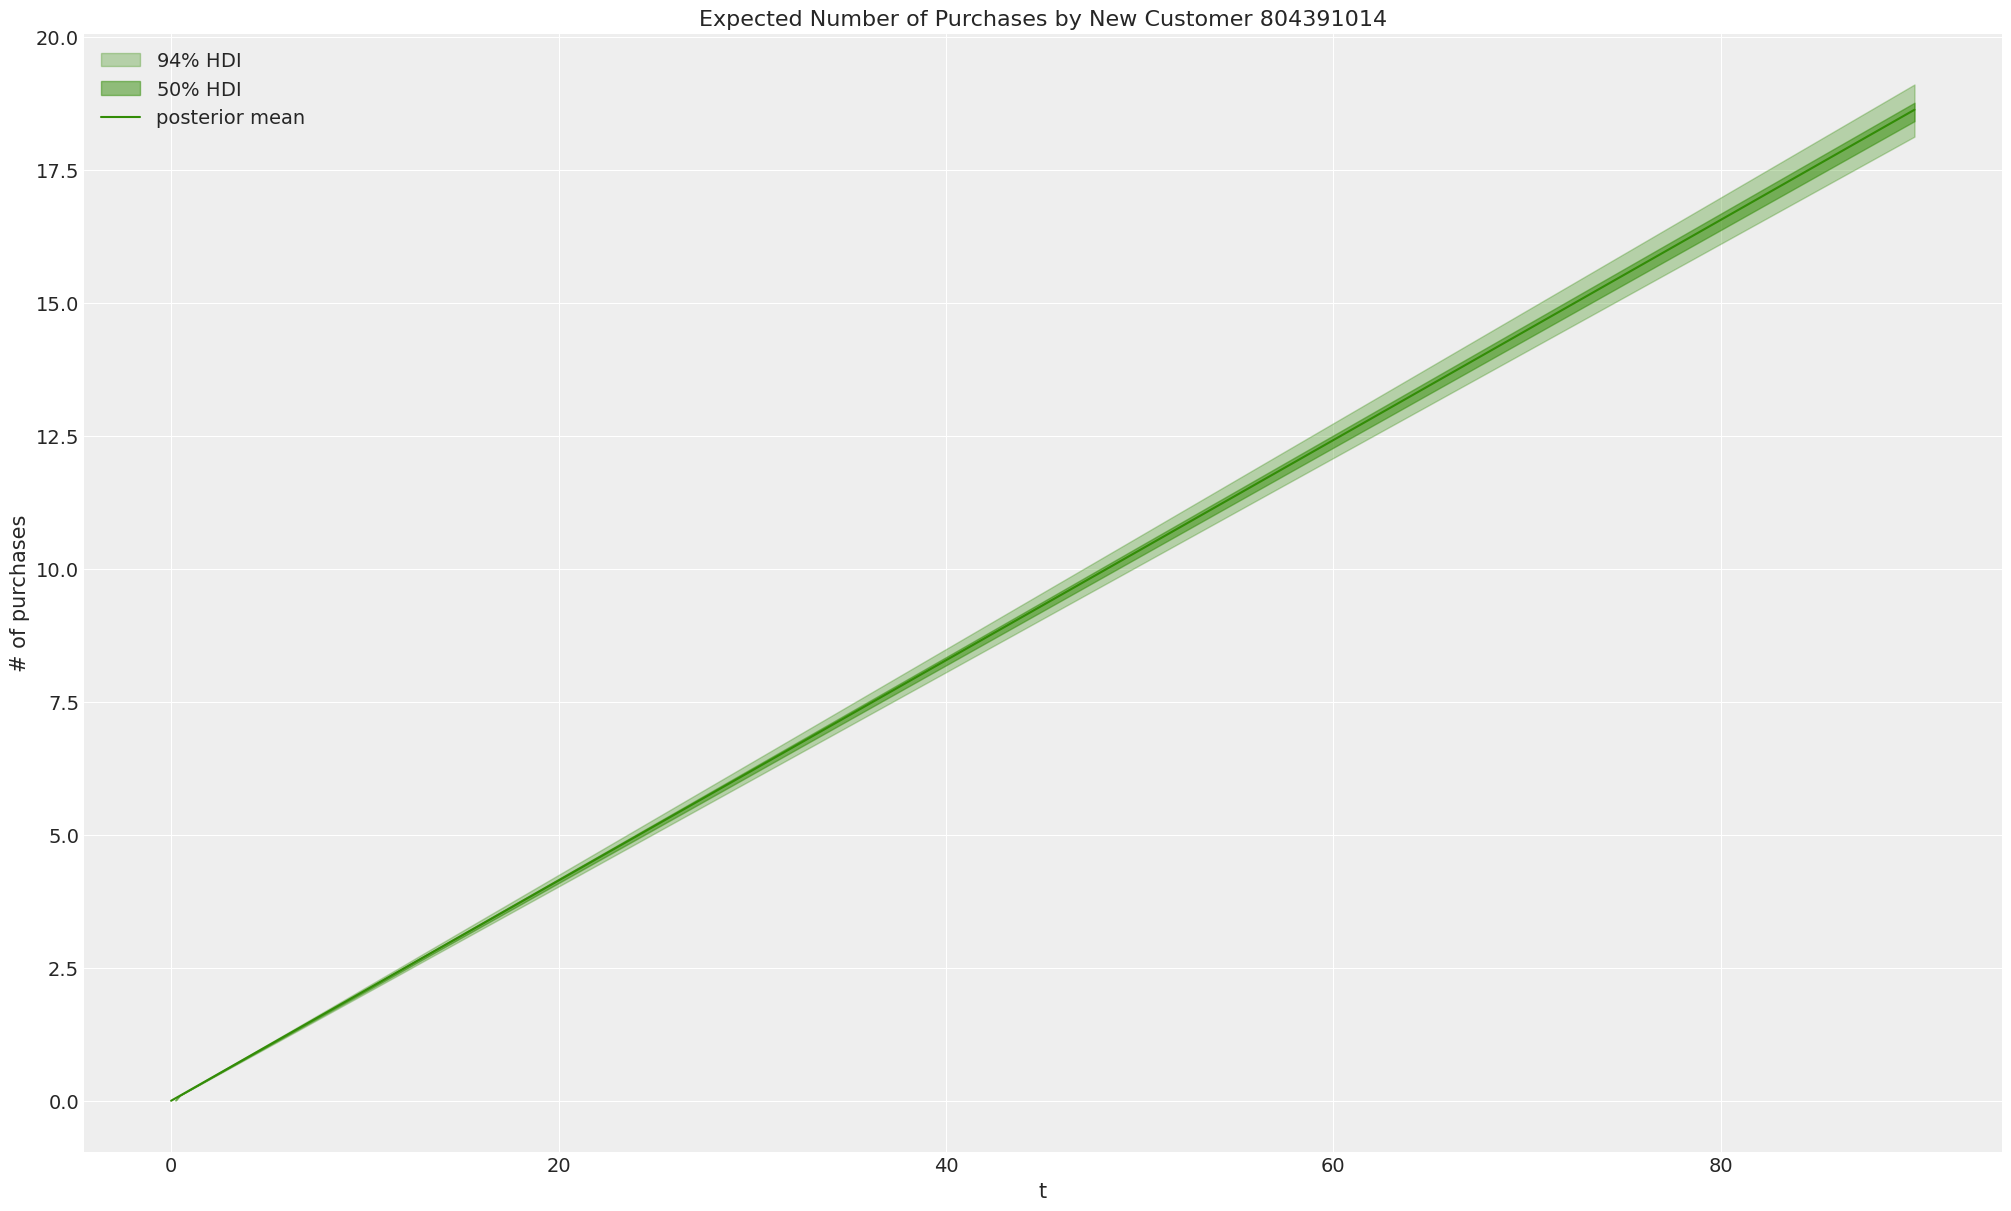

In [125]:
expected_purchases_over_time_new_customer = concat(
    objs=[
        pnbd_model.expected_purchases_new_customer(
            data=train_data,
            t=t,
        ).sel(customer_id=account_id)
        for t in tqdm(t_range)
    ],
    dim="t",
).transpose(..., "t")

ax = plt.axes()
# Set the figure size
ax.figure.set_size_inches(20, 12)

az.plot_hdi(
    t_range,
    expected_purchases_over_time_new_customer,
    hdi_prob=0.94,
    color="C2",
    fill_kwargs={"alpha": 0.3, "label": "$94 \\%$ HDI"},
    ax=ax,
)
az.plot_hdi(
    t_range,
    expected_purchases_over_time_new_customer,
    hdi_prob=0.5,
    color="C2",
    fill_kwargs={"alpha": 0.5, "label": "$50 \\%$ HDI"},
    ax=ax,
)
ax.plot(
    t_range,
    expected_purchases_over_time_new_customer.mean(dim=("chain", "draw")),
    color="C2",
    label="posterior mean",
)
ax.legend(loc="upper left")
ax.set(
    title=f"Expected Number of Purchases by New Customer {account_id}",
    ylabel="# of purchases",
    xlabel="t",
)
plt.show();

### Probability of $n$ Transactions Over Time

In [126]:
account_id: str = str(rng.choice(train_data["customer_id"], size=1)[0])
n_purchases_array: np.ndarray = np.repeat([1, 3, 6, 9, 12, 15], 6)
time_periods_array: np.ndarray = np.tile([15, 30, 45, 60, 75, 90], 6)

# Calculate expected purchase probabilities for each (n_purchases, future_t) combination
results = [
    pnbd_model.expected_purchase_probability(
        data=train_data,
        n_purchases=n_purchases,
        future_t=time_periods,
    ).sel(customer_id=account_id)
    for n_purchases, time_periods in tqdm(
        zip(n_purchases_array, time_periods_array, strict=False),
        total=len(n_purchases_array),
        desc="Calculating expected purchase probabilities",
    )
]

# Concatenate the results along the customer_id dimension
expected_purchase_prob: DataArray = concat(results, dim="customer_id")

# Collapse any extra dimensions (e.g. a "draw" dimension) to get one value per combination
expected_purchase_prob: DataArray = expected_purchase_prob.mean(dim=["chain", "draw"])

Calculating expected purchase probabilities: 100%|██████████| 36/36 [05:14<00:00,  8.73s/it]


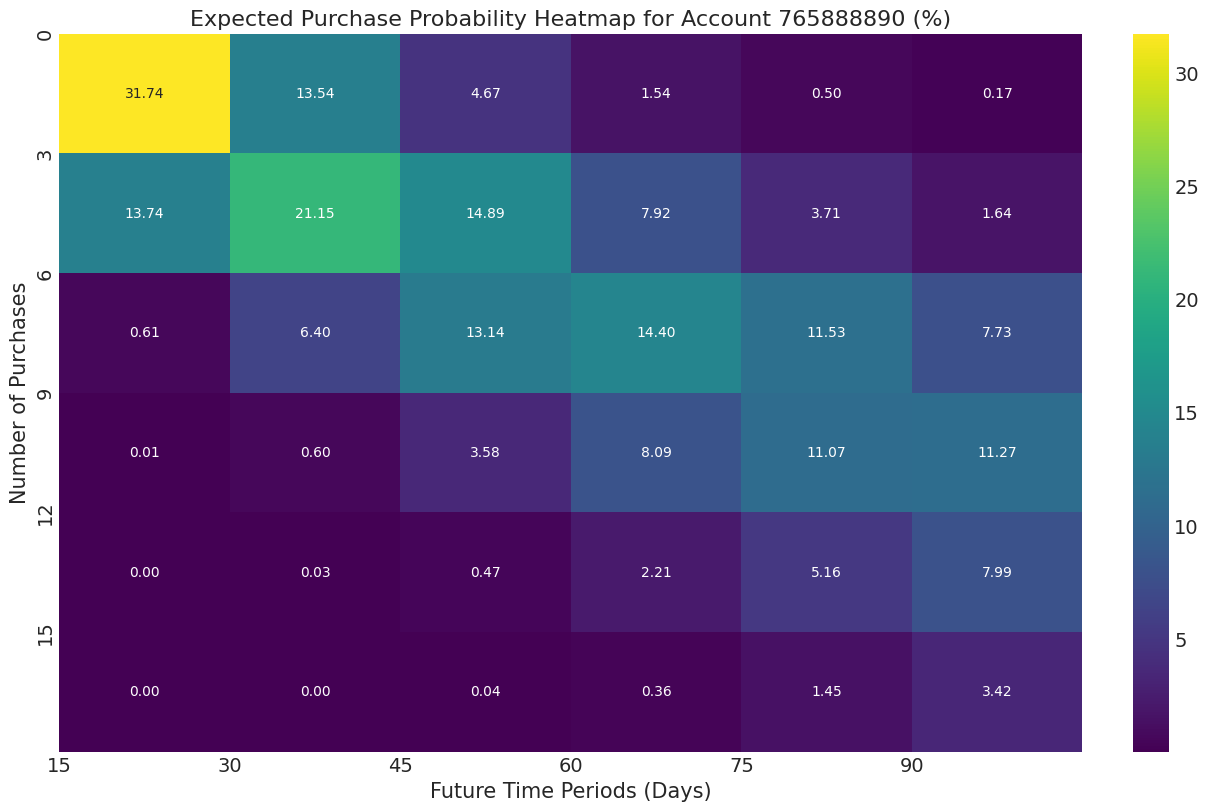

In [128]:
heatmap_values: np.ndarray = expected_purchase_prob.values.reshape(6, 6) * 100

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(heatmap_values, annot=True, fmt=".2f", cmap="viridis", ax=ax)
plt.title(f"Expected Purchase Probability Heatmap for Account {account_id} (%)")
plt.xlabel("Future Time Periods (Days)")
plt.ylabel("Number of Purchases")
plt.xticks(ticks=range(6), labels=[15, 30, 45, 60, 75, 90])
plt.yticks(ticks=range(6), labels=[0, 3, 6, 9, 12, 15])
plt.show();

## Spend Per Transaction Model

The Gamma-Gamma model is based on the following assumptions:

1. **Transaction Values**: The monetary value of a customer's transaction varies randomly around their average transaction value.
2. **Stability of Average Transaction Value**: The average transaction value varies across customers but does not vary over time for any given individual.
3. **Independence**: The distribution of average transaction values across customers is independent of the transaction process.

For a customer with $ x $ transactions, let $ z_1, z_2, \ldots, z_x $ denote the value of each transaction. The customer's observed average transaction value is given by:

$$
\bar{z} = \frac{1}{x} \sum_{i=1}^x z_i
$$

### Parametrization

1. **Per-Transaction Gamma Distribution**:
   - Each transaction value $ z_i $ is assumed to follow a Gamma distribution with shape parameter $ p $ and rate parameter $ \nu $:
     $$
     z_i \sim \text{Gamma}(p, \nu)
     $$
   - The expected value of $ z_i $ is $ \xi = \frac{p}{\nu} $, which represents the average transaction value for a customer.

2. **Total Spend Across Transactions**:
   - The total spend across $ x $ transactions follows a Gamma distribution:
     $$
     \text{Total Spend} \sim \text{Gamma}(p x, \nu)
     $$
   - The average transaction value $ \bar{z} $ follows a Gamma distribution:
     $$
     \bar{z} \sim \text{Gamma}(p x, \nu x)
     $$

3. **Heterogeneity in $ \nu $**:
   - The rate parameter $ \nu $ varies across customers and follows a Gamma distribution with shape parameter $ q $ and rate parameter $ \gamma $:
     $$
     \nu \sim \text{Gamma}(q, \gamma)
     $$

Filter out customers who have made only one purchase:

In [14]:
train_data_non_zero: pd.DataFrame = train_data.loc[train_data["frequency"] > 0]

train_data_non_zero.shape

(4893, 5)

### Independence Assumption Asessment

The Gamma-Gamma model assumes that there is **no relationship** between the monetary value and the purchase frequency.

When we’re dealing with large datasets, even very small correlations can become “statistically significant” due to high power, even if they are practically negligible. To robustly check the assumption that average spend and purchase frequency are uncorrelated (as required by the Gamma-Gamma model), we can use methods that are less sensitive to outliers and the nuances of big data.

#### Rank-Based Correlation Measures

Rank-based methods (e.g., Spearman’s rank correlation and Kendall’s tau) are non-parametric. They assess monotonic relationships rather than strict linear relationships and are less sensitive to outliers. This makes them more robust in many real-world settings.

In [15]:
pearson_res = pearsonr(
    x=train_data_non_zero["frequency"], y=train_data_non_zero["monetary_value"]
)

spearman_res = spearmanr(
    a=train_data_non_zero["frequency"], b=train_data_non_zero["monetary_value"]
)

kendall_res = kendalltau(
    x=train_data_non_zero["frequency"], y=train_data_non_zero["monetary_value"]
)


print(f"Pearson Correlation: {pearson_res[0]:.2f} | p-value: {pearson_res[1]:.2f}")
print(
    f"Spearman Correlation: {spearman_res.statistic:.2f} | p-value: {spearman_res.pvalue:.2f}"
)
print(f"Kendall Tau: {kendall_res.statistic:.2f} | p-value: {kendall_res.pvalue:.2f}")

Pearson Correlation: 0.43 | p-value: 0.00
Spearman Correlation: 0.62 | p-value: 0.00
Kendall Tau: 0.48 | p-value: 0.00


#### Robust Regression & Outlier-Robust Techniques

Outliers or influential points can distort the results. Robust regression methods help in understanding the relationship while down-weighting the effect of outliers.

In [16]:
scaled_monetary_value: np.ndarray = (
    RobustScaler()
    .fit_transform(train_data_non_zero["monetary_value"].values.reshape(-1, 1))
    .reshape(-1)
)

X: np.ndarray = sm.add_constant(scaled_monetary_value)

# Fit robust linear model
rlm_model: RLM = RLM(
    endog=train_data_non_zero["frequency"], exog=X, M=sm.robust.norms.HuberT()
)
rlm_results: RLMResultsWrapper = rlm_model.fit()
rlm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:              frequency   No. Observations:                 4893
Model:                            RLM   Df Residuals:                     4891
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 05 Feb 2025                                         
Time:                        00:47:51                                         
No. Iterations:                    36                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         47.1029      0.516     91.214      0.000      46.091      48.115
x1            29.5813      0.177    167.250      0.000      29.235      29.928
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

#### Bootstrapping for Confidence Intervals

Bootstrapping can provide confidence intervals for correlation coefficients. This is particularly useful in large datasets where even small effects become statistically significant. Bootstrapped intervals can help us assess whether the magnitude of the correlation is practically meaningful.

In [17]:
for func in ["pearson", "spearman"]:
    ci: np.ndarray = pg.compute_bootci(
        x=train_data_non_zero["frequency"],
        y=train_data_non_zero["monetary_value"],
        func=func,
        paired=True,
        confidence=0.95,
        n_boot=5000,
        seed=seed,
    )
    print(
        f"Correlation between Frequency and Monetary Value using {func} correlation: "
        f"{ci[0]:.2f} - {ci[1]:.2f}"
    )

Correlation between Frequency and Monetary Value using pearson correlation: 0.33 - 0.59
Correlation between Frequency and Monetary Value using spearman correlation: 0.59 - 0.64


### Empirical Distribution of Monetary Values

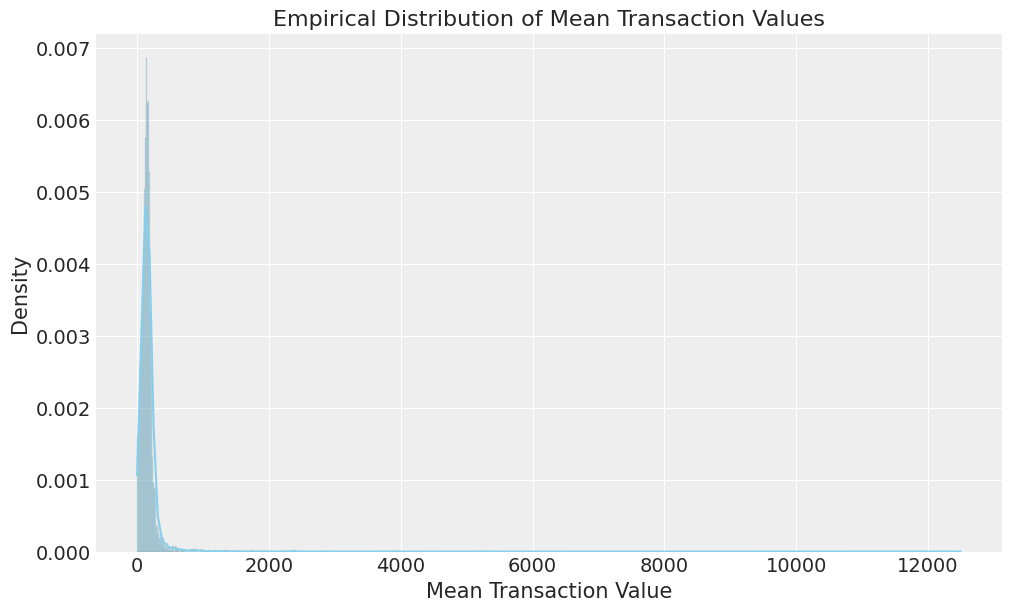

In [18]:
monetary_values: np.ndarray = train_data_non_zero["monetary_value"].values

plt.figure(figsize=(10, 6))
sns.histplot(
    monetary_values,
    bins=np.histogram_bin_edges(a=monetary_values, bins="auto"),
    kde=True,
    stat="density",
    color="skyblue",
    edgecolor="black",
)
plt.title("Empirical Distribution of Mean Transaction Values")
plt.xlabel("Mean Transaction Value")
plt.ylabel("Density")
plt.show();

Use scipy's `gamma` distribution to fit the empirical distribution of monetary values:

In [19]:
a_fit, loc_fit, scale_fit = gamma.fit(monetary_values)
print(f"Fitted parameters: shape = {a_fit}, rate = {1 / scale_fit:.3f}")

Fitted parameters: shape = 0.00023299656497147901, rate = 0.236


### Prior Specifications

The Gamma-Gamma model parameters $ p $, $ q $, and $ \nu $ are estimated using Bayesian inference. Again, the priors for these parameters are informed by MLE estimates from a frequentist Gamma-Gamma model fit to the data. This approach ensures that the priors are centered around reasonable values, improving the stability and predictive performance of the Bayesian model.

1. **Fit a frequentist Gamma-Gamma model** to the RFM data:

   - `frequency`: Total number of repeat purchases for each customer.
   - `monetary_value`: Mean (or total) spend for those repeat purchases.

2. **Extract the MLE parameters** $(p, q, \nu) $ from the fitted model.

3. **Map MLE estimates into Bayesian priors**:

   - For $ p $ and $ q $, the priors are directly set using the MLE estimates with means $\frac{\text{shape}}{\text{rate}} = \frac{\text{MLE}}{1.0}$:
     $$
     p_{\text{prior}} = \text{Prior}(\text{Gamma}, \alpha=p_{\text{MLE}}, \beta=1.0)
     $$
     $$
     q_{\text{prior}} = \text{Prior}(\text{Gamma}, \alpha=q_{\text{MLE}}, \beta=1.0)
     $$

   - For $ \nu $, the prior can either use the MLE estimate or a default moderate prior:
     $$
     \nu_{\text{prior}} = \text{Prior}(\text{Gamma}, \alpha=2.0, \beta=\nu_{\text{MLE}}) \quad \text{(if using MLE)}
     $$
     $$
     \nu_{\text{prior}} = \text{Prior}(\text{Gamma}, \alpha=2.0, \beta=0.2) \quad \text{(default)}
     $$


In [20]:
model_config_mle_spend: Dict[str, Prior] = create_spend_model_config_mle(
    rfm_data=train_data_non_zero,
    use_mle_for_v=True,
)

model_config_mle_spend

{'p_prior': Prior("Gamma", alpha=0.28028877567967475, beta=1.0),
 'q_prior': Prior("Gamma", alpha=6.750471754913227, beta=1.0),
 'v_prior': Prior("Gamma", alpha=2.0, beta=3629.9758366029264)}

#### $p_{\text{prior}}$

In [21]:
p_alpha_prior: float = model_config_mle_spend["p_prior"].parameters["alpha"]
p_beta_prior: float = model_config_mle_spend["p_prior"].parameters["beta"]
p_prior_mean: float = p_alpha_prior / p_beta_prior

print("Prior mean for p:", p_prior_mean)

Prior mean for p: 0.28028877567967475


This suggests that the average transaction value is relatively low, as $p$ influences the shape of the Gamma distribution for transaction values.

#### $q_{\text{prior}}$

In [22]:
q_alpha_prior: float = model_config_mle_spend["q_prior"].parameters["alpha"]
q_beta_prior: float = model_config_mle_spend["q_prior"].parameters["beta"]
q_prior_mean: float = q_alpha_prior / q_beta_prior

print("Prior mean for q:", q_prior_mean)

Prior mean for q: 6.750471754913227


A higher $q$ indicates less variability in the rate parameter $\nu$, which controls the spread of transaction values around the average across customers.

#### $\nu_{\text{prior}}$

In [23]:
v_alpha_prior: float = model_config_mle_spend["v_prior"].parameters["alpha"]
v_beta_prior: float = model_config_mle_spend["v_prior"].parameters["beta"]
v_prior_mean: float = v_alpha_prior / v_beta_prior

print("Prior mean for v:", v_prior_mean)

Prior mean for v: 0.000550967854891199


A very small $\nu$ suggests that the average transaction value $\xi=\frac{p}{\nu}$ is relatively high, as $\nu$ is inversely related to $\xi$.

#### Expected Average Transaction Value ($\xi$)

The prior specification has assumptions regarding the expected average transaction value $\xi$ for customers baked into the model:

In [24]:
prior_expected_spend: float = p_prior_mean / v_prior_mean

print(
    f"Expected Spend: {prior_expected_spend:.2f} | Actual Average Spend: {monetary_values.mean():.2f}"
)

Expected Spend: 508.72 | Actual Average Spend: 163.81


### Model Fitting

#### Model

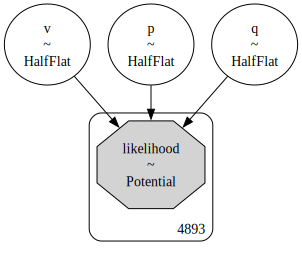

In [25]:
gg_model: GammaGammaModel = GammaGammaModel(data=train_data_non_zero, model_config=None)
gg_model.build_model()
gg_model.graphviz()

#### Maximum A Posteriori (MAP) Estimate

In [26]:
idata_map: pd.DataFrame = gg_model.fit(fit_method="map").posterior.to_dataframe()

Output()

In [27]:
idata_map

,,p,q,v
chain,draw,,,
0,0,0.280288,6.750407,3629.947481


#### MCMC 

In [28]:
idata_mcmc: az.InferenceData = gg_model.fit(
    fi_method="mcmc", **{"draws": 2000, "chains": 4, "random_seed": seed, "tune": 2000}
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, q, v]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 18 seconds.


In [29]:
gg_model.fit_summary()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.280,0.009,0.264,0.298,0.000,0.000,2695.0,3468.0,1.0
q,6.766,0.208,6.377,7.151,0.004,0.003,2213.0,3007.0,1.0
v,3644.663,203.954,3280.256,4034.507,4.565,3.228,1994.0,2485.0,1.0


Persist model:

In [66]:
gg_model.save(str(model_path / "gg_model.nc"))

#### Model Trace

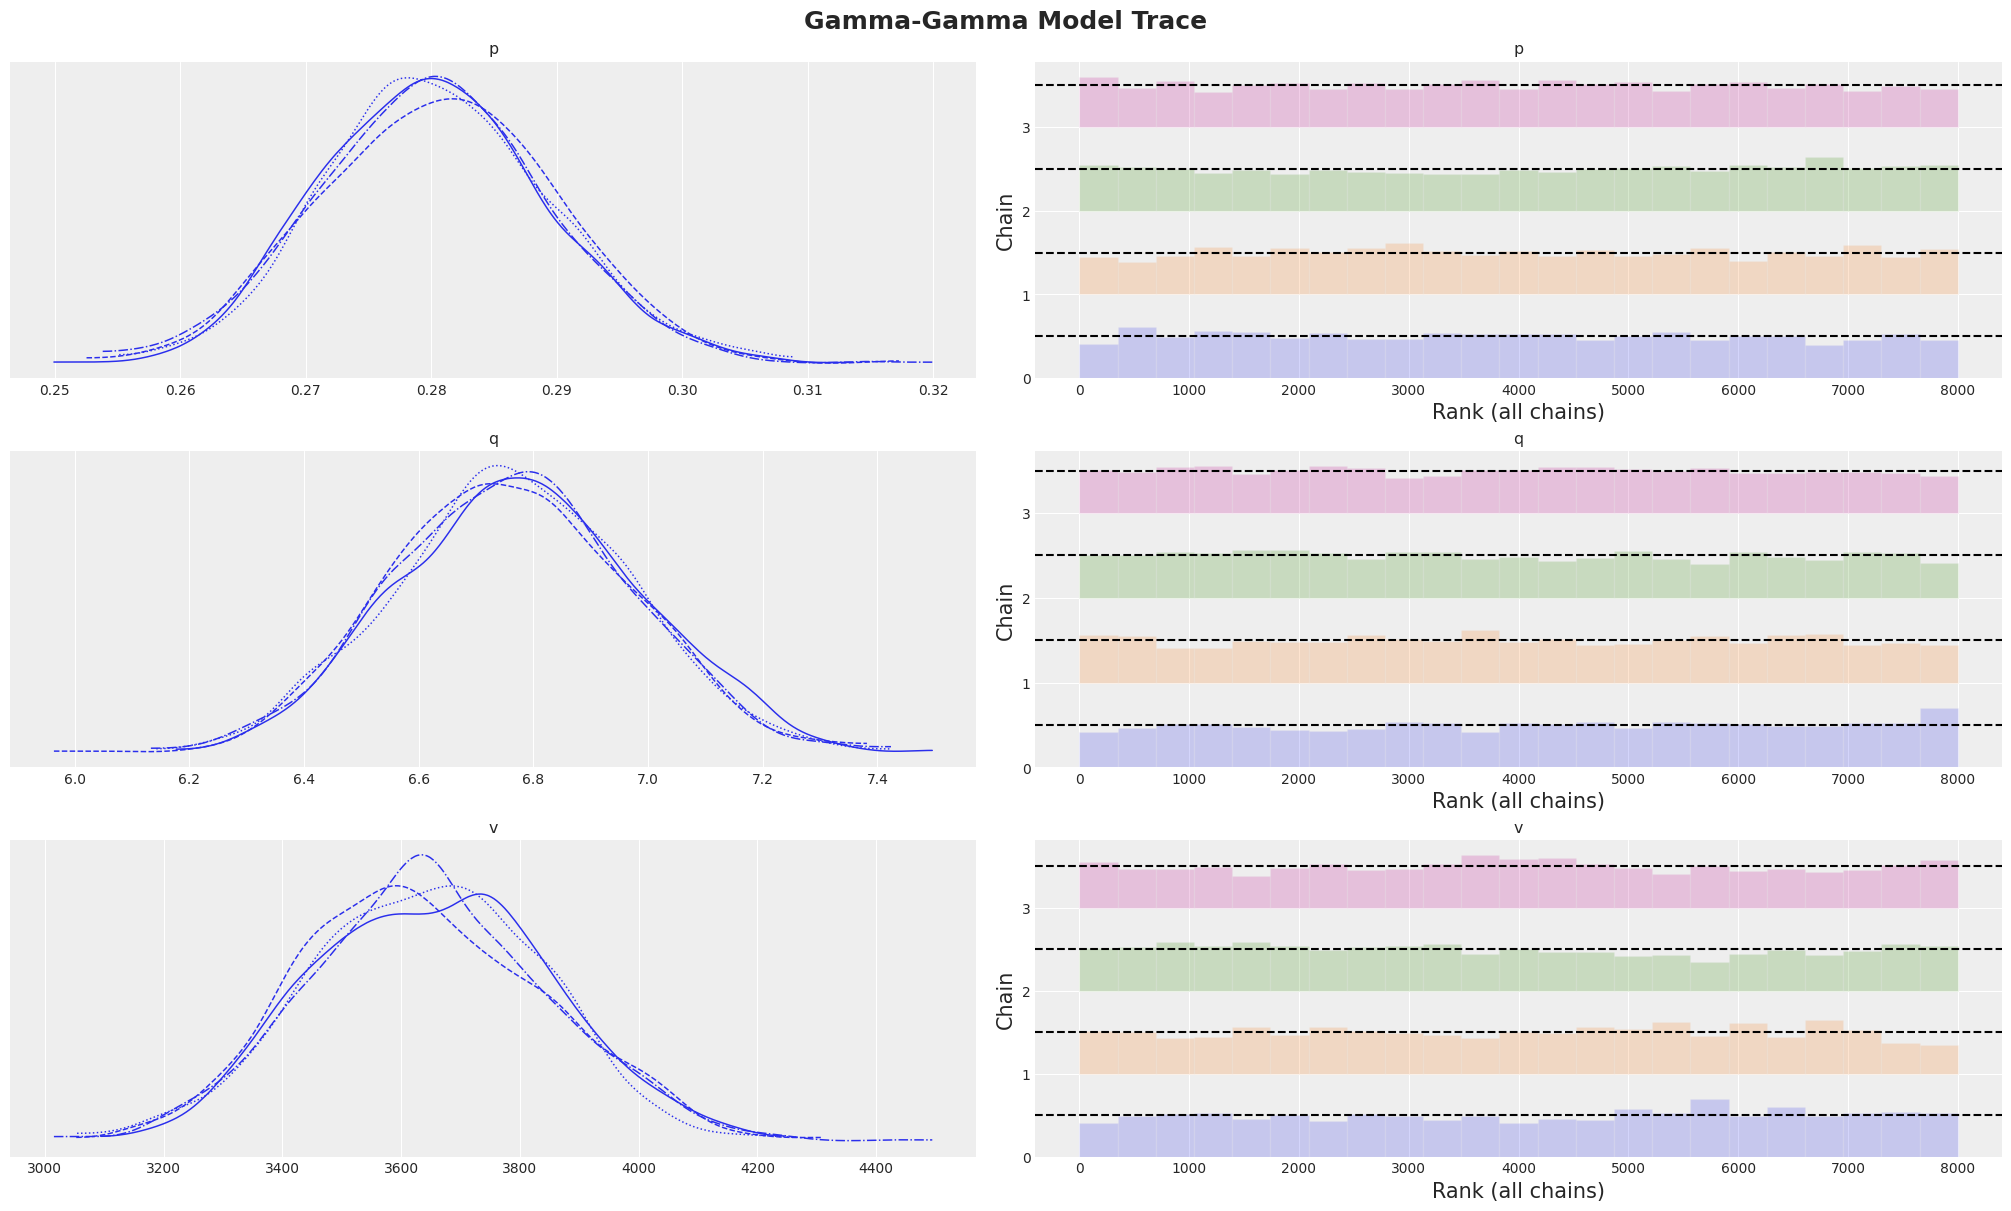

In [30]:
az.plot_trace(
    idata_mcmc,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (20, 12), "layout": "constrained"},
)
plt.gcf().suptitle("Gamma-Gamma Model Trace", fontsize=18, fontweight="bold");

#### Comparison With MAP Estimate

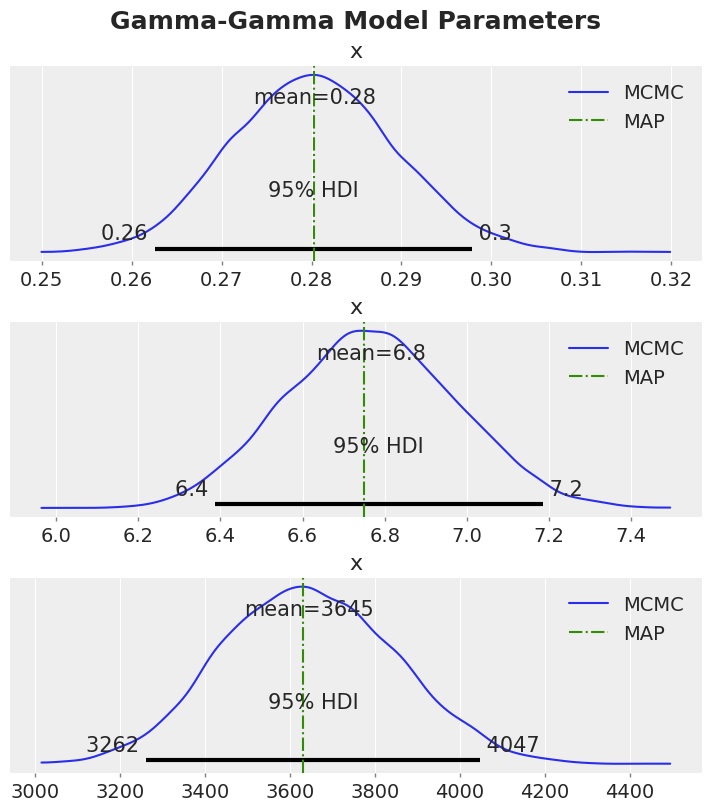

In [31]:
fig, axes = plt.subplots(
    nrows=3, ncols=1, figsize=(7, 8), sharex=False, sharey=False, layout="constrained"
)

for i, var_name in enumerate(["p", "q", "v"]):
    ax = axes[i]
    az.plot_posterior(
        idata_mcmc.posterior[var_name].values.flatten(),
        color="C0",
        point_estimate="mean",
        hdi_prob=0.95,
        ax=ax,
        label="MCMC",
    )
    ax.axvline(x=idata_map[var_name].item(), color="C2", linestyle="-.", label="MAP")
    ax.legend(loc="upper right")

plt.gcf().suptitle("Gamma-Gamma Model Parameters", fontsize=18, fontweight="bold");

## Expected Account Spend

In [32]:
expected_spend: DataArray = gg_model.expected_customer_spend(
    data=train_data_non_zero,
)

expected_spend.shape

(4, 2000, 4893)

#### Summary

In [33]:
summary: pd.DataFrame = az.summary(data=expected_spend, kind="stats")

summary

,mean,sd,hdi_3%,hdi_97%
x[100088067],136.793,0.865,135.183,138.420
x[100108752],136.145,1.843,132.623,139.536
x[100328049],164.403,0.447,163.568,165.216
x[100663626],165.755,0.939,163.989,167.465
x[100737756],229.676,0.550,228.686,230.748
...,...,...,...,...
x[999086814],296.378,0.561,295.338,297.399
x[999257059],199.900,0.330,199.287,200.519
x[999258704],137.655,0.782,136.209,139.136
x[999283629],174.721,0.291,174.197,175.282


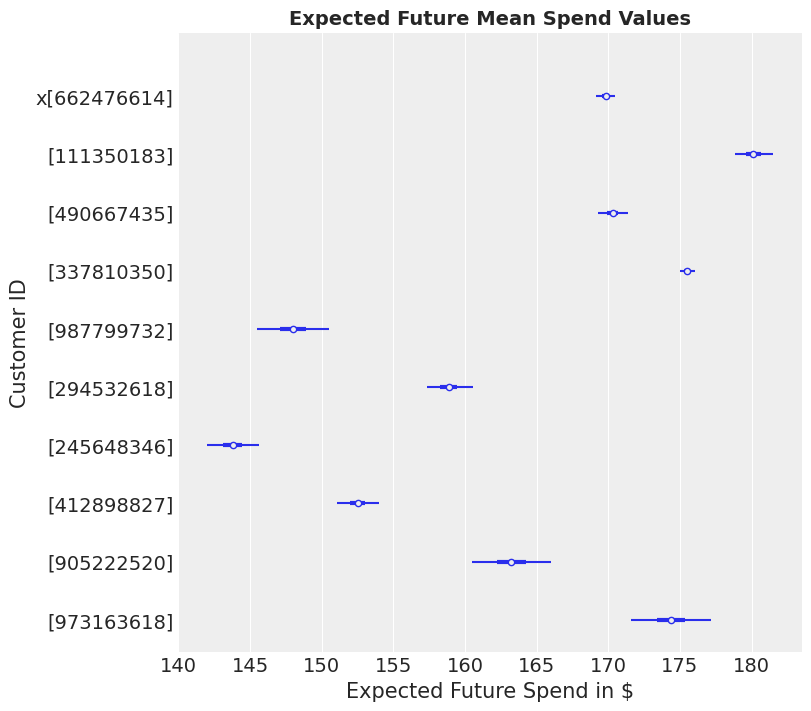

In [59]:
accounts: np.ndarray = rng.choice(
    range(train_data_non_zero.shape[0]), size=10, replace=False
).tolist()

ax, *_ = az.plot_forest(
    data=expected_spend.isel(customer_id=accounts), combined=True, figsize=(8, 7)
)
ax.set(xlabel="Expected Future Spend in $", ylabel="Customer ID")
ax.set_title("Expected Future Mean Spend Values", fontsize=14, fontweight="bold");

#### Expected Spend Distribution

In [53]:
mean_expected_spend: DataArray = expected_spend.mean(dim="customer_id")
hdi_prob: float = 0.97
hdi_expected_spend: DataArray = az.hdi(expected_spend, hdi_prob=hdi_prob).to_array()
hdi_lower: float = hdi_expected_spend.sel(hdi="lower").mean(dim="customer_id").item()
hdi_upper: float = hdi_expected_spend.sel(hdi="higher").mean(dim="customer_id").item()

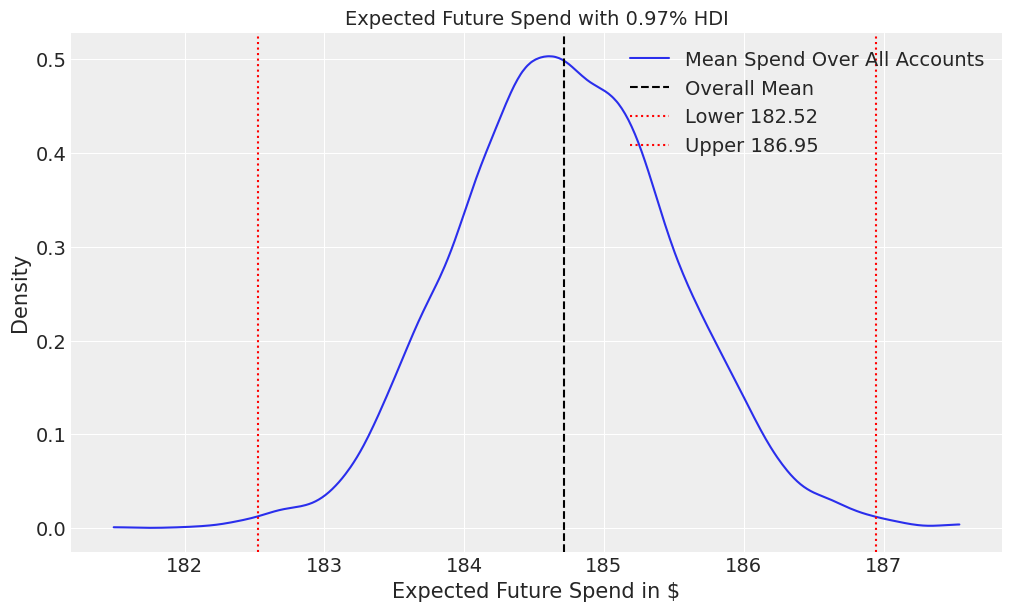

In [55]:
fig, ax = plt.subplots(figsize=(10, 6))
az.plot_dist(mean_expected_spend, label="Mean Spend Over All Accounts", ax=ax)
ax.axvline(
    x=mean_expected_spend.mean().item(), color="black", ls="--", label="Overall Mean"
)

# Adding HDI lines
ax.axvline(hdi_lower, color="red", linestyle=":", label=f"Lower {hdi_lower:.2f}")
ax.axvline(hdi_upper, color="red", linestyle=":", label=f"Upper {hdi_upper:.2f}")

# Customizing plot
ax.legend(loc="upper right")
ax.set(xlabel="Expected Future Spend in $", ylabel="Density")
ax.set_title(
    f"Expected Future Spend with {hdi_prob}% HDI",
    fontsize=14,
)

plt.show();

#### Posterior Distribution for New Accounts

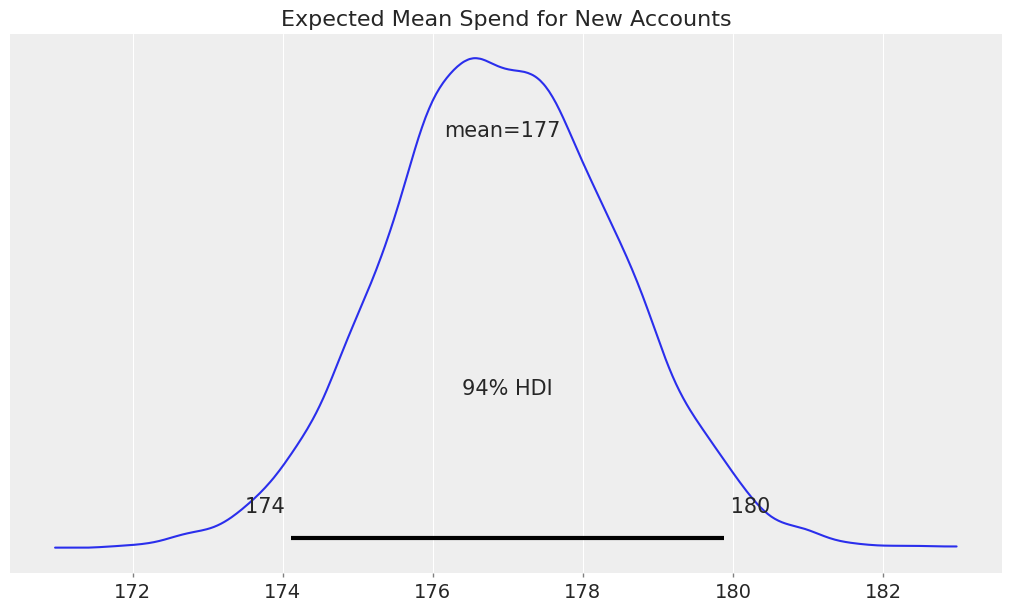

In [64]:
fig, ax = plt.subplots(figsize=(10, 6))
az.plot_posterior(data=gg_model.expected_new_customer_spend(), ax=ax)
plt.title("Expected Mean Spend for New Accounts");

## Customer Lifetime Value (CLV)

When combining **Gamma-Gamma** (for *average spend*) with a **Pareto/NBD** model (for *number of future transactions*), we can estimate each customer’s **lifetime value** (CLV) by summing discounted cash flows over future periods.

### 1. Pareto/NBD: Predicting Future Transactions

- **Pareto/NBD** assumes each customer is active for an unobserved amount of time, then permanently “drops out.”  
- It models:
  $$
    \lambda \sim \Gamma(r, \alpha) \quad\text{(purchase rate)},
    \quad
    \mu \sim \Gamma(s, \beta) \quad\text{(dropout rate)},
  $$
  and provides $\mathbb{E}[N_t]$, the *cumulative* expected number of transactions by time $t$.

### 2. Gamma-Gamma: Predicting Average Spend

- **Gamma-Gamma** models average transaction value $\bar{z}$.  
- Each customer $i$ has frequency $x_i$. Conditioned on $\nu_i \sim \Gamma(q, v)$, the observed mean spend $\bar{z}_i$ follows:
  $$
    \bar{z}_i \;\big|\;\nu_i \;\sim\; \Gamma\bigl(p\,x_i,\;\nu_i\,x_i\bigr).
  $$
- From its posterior on $(p,q,v)$, it yields an expected average spend $\mathbb{E}[\text{Spend}_i]$.

### 3. Discounted Cash Flow Formulation

To compute **customer lifetime value** (CLV) over a horizon of $T$ periods:

$$
\text{CLV}_i \;=\; \sum_{t=1}^{T} 
  \frac{\bigl(\Delta N_{i,t}\bigr)\times \mathbb{E}[\text{Spend}_i]}
  {\bigl(1 + \delta\bigr)^{t}},
$$

where
- $\delta$ = monthly discount rate,
- $\Delta N_{i,t} = \mathbb{E}[N_{i,t}] - \mathbb{E}[N_{i,t-1}]$ are *new* transactions predicted at period $t$,
- $\mathbb{E}[\text{Spend}_i]$ is the Gamma-Gamma–based expected average spend.

### 4. Implementation Details

- **`expected_purchases(data, future_t)`** from the Pareto/NBD model: returns $\mathbb{E}[N_t]$, the *cumulative* number of transactions by time $t$.  
- **`expected_customer_spend(data)`** from the Gamma-Gamma model: returns $\mathbb{E}[\text{Spend}_i]$.  
- **`customer_lifetime_value(transaction_model, data, future_t, discount_rate, time_unit)`**:
  1. Uses the Gamma-Gamma predictions to assign a column `future_spend` = $\mathbb{E}[\text{Spend}_i]$.  
  2. Loops through monthly increments of time (converted to days/weeks if needed).  
  3. Gets incremental transactions $\Delta N_t$ from the **Pareto/NBD** cumulative predictions.  
  4. Sums $\Delta N_t \times \mathbb{E}[\text{Spend}]$, discounted by $(1 + \delta)^{-t}$.

The final **xarray** `DataArray` returned contains the estimated CLV for each customer, reflecting both **average spend** (Gamma-Gamma) and **transaction frequency** (Pareto/NBD) over the specified horizon with optional discounting.

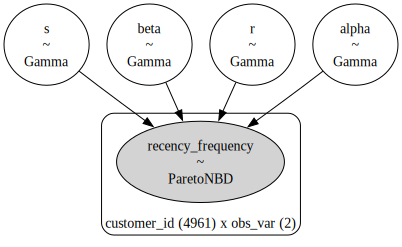

In [65]:
pnbd_model: ParetoNBDModel = ParetoNBDModel.load(
    str(model_path / "pnbd_model_thin_20.nc")
)

pnbd_model.graphviz()

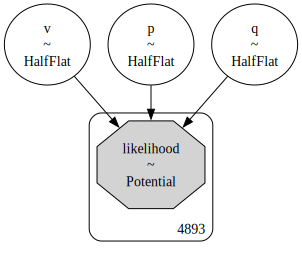

In [67]:
gg_model: GammaGammaModel = GammaGammaModel.load(str(model_path / "gg_model.nc"))

gg_model.graphviz()

### Customer Lifetime Value (CLV) Calculation

In [ ]:
future_t_in_months: int = 12
monthly_discount_rate: float = 0.01

clv_estimates: DataArray = gg_model.expected_customer_lifetime_value(
    transaction_model=pnbd_model,
    data=train_data,
    future_t=future_t_in_months,  # This must be in months
    discount_rate=monthly_discount_rate,  # This also must be in months
    time_unit="D",
)

In [71]:
clv_summaries: pd.DataFrame = az.summary(data=clv_estimates, kind="stats")
clv_summaries

,mean,sd,hdi_3%,hdi_97%
x[100088067],8135.667,2.163,8131.731,8139.576
x[100108752],3657.101,3.888,3649.810,3664.309
x[100328049],12456.966,3.152,12451.175,12462.796
x[100663626],3789.523,2.818,3784.591,3795.058
x[100737756],27673.423,7.843,27658.485,27687.909
...,...,...,...,...
x[999086814],79243.667,26.639,79197.232,79296.470
x[999257059],24244.892,6.860,24231.335,24257.040
x[999258704],8898.625,2.228,8894.569,8902.639
x[999283629],19323.257,5.220,19313.436,19332.693


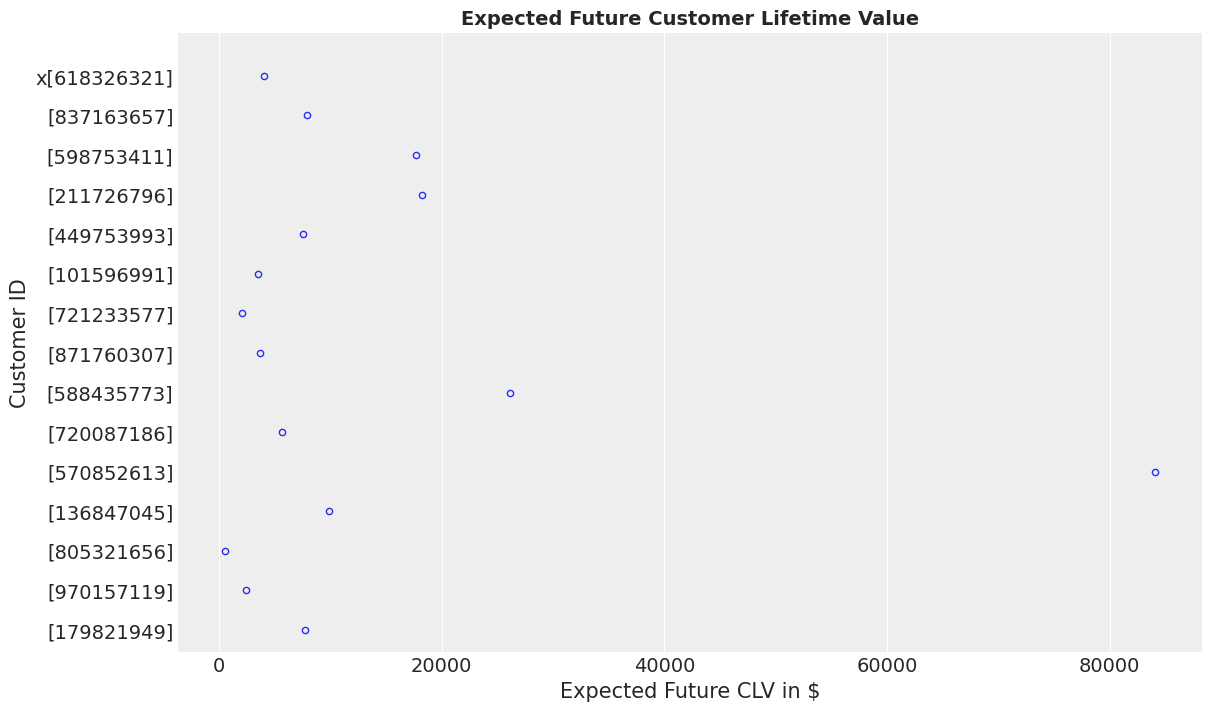

In [87]:
accounts: np.ndarray = rng.choice(
    range(train_data.shape[0]), size=15, replace=False
).tolist()

az.plot_forest(
    data=clv_estimates.isel(customer_id=accounts), combined=True, figsize=(12, 7)
)
plt.xlabel("Expected Future CLV in $")
plt.ylabel("Customer ID")
plt.title("Expected Future Customer Lifetime Value", fontsize=14, fontweight="bold")
plt.show();

### Interpretation

#### Layperson-Friendly Explanation

> We have a table that shows, for each account, an **expected lifetime value**—how much we predict they’ll spend in total. The **mean** is our best guess for each person’s total spend over the time period (12 months), while **sd** tells us how uncertain we are: a bigger number means more variability in that prediction.
> 
> The **3%** and **97%** columns show what we call a “credible interval”—this is a range that’s likely to contain the true value. For example, for the first account, the mean is about 8,135 dollars, and we estimate there’s only a 3% chance the true value is below about 8,131 dollars, and only a 3% chance it’s above about 8,139 dollars. 
> 
> Keep in mind that these figures come from a **probabilistic model** (Pareto/NBD for transactions plus Gamma-Gamma for spending), which uses past data to project the future. That means the predictions assume behavior stays roughly consistent and that the model’s assumptions hold true.


#### More Technical / Rigorous Explanation

> Each row corresponds to a single account’s **posterior distribution** of estimated lifetime value (CLV), integrating over both their predicted number of future transactions (via Pareto/NBD) and their predicted average transaction amount (via Gamma-Gamma). We summarize this posterior by four key statistics:
> 
> 1. **mean**: The posterior mean of the account’s predicted total monetary value.
> 2. **sd**: The posterior standard deviation, reflecting how spread out or uncertain the estimate is.
> 3. **hdi_3%** and **hdi_97%**: These are the lower and upper bounds of the 94% highest-density interval (HDI). Concretely, there’s a 94% probability that the true CLV for this account lies within that range, under our model’s assumptions.
> 
> For instance, if we look at account **999389635**, we see:
> - A **mean** of about 1,314.63 dollars, meaning that on average, our model thinks this account’s lifetime value will be around $1,315.
> - A **sd** of roughly 3.58, indicating modest uncertainty.
> - A **hdi_3%** of about 1,307.81 and **hdi_97%** of about 1,321.13, so there’s relatively little range—our model is quite confident this account’s CLV will be in the low thirteen-hundreds.
> 
> However, these estimates rely on key assumptions of the Pareto/NBD + Gamma-Gamma models: **stationary purchasing rates**, consistent spending behavior, and a particular prior distribution for parameters. If real account behavior changes in ways not captured by the model, the estimates could be off.


#### Key Caveats & Assumptions to Mention

1. **Historical Behavior**: The model extrapolates from each account’s past transactions, assuming future habits remain similar.
2. **External Factors**: Promotions, economic shifts, or changes in account needs can invalidate these estimates.
3. **Model Uncertainty**: Even if the mean looks precise, a wide standard deviation or wide credible interval implies much uncertainty in that particular account’s outcome.
4. **Discount Rate**: If we incorporate discounting, the final dollar figures might shift to reflect present-value assumptions. If we haven’t applied discounting, that’s another assumption (money doesn’t lose value over time).

All told, these numbers provide **probabilistic** guidance about future spending, not guarantees.